# Visualizations

Content:
1. Data exploration (initial)
2. mSBM results
3. Classification


In [1]:
# preamble
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import metrics
from scipy.special import gamma, beta, gammaln, betaln
import nilearn as ni
from nilearn import plotting as nplt
from nilearn.maskers import NiftiLabelsMasker
import nilearn.connectome
import nibabel as nib
import networkx as nx
from matplotlib.colors import ListedColormap
from ast import literal_eval

from sklearn.datasets import load_iris

# my functions
from helper_functions import *

## 1. Data exploration

### 1.1 MR images and demographic info
Playing out with different nilearn visualization tools

fMRIprep article: https://www.nature.com/articles/s41592-018-0235-4 

In [2]:
main_dir = '/work3/s174162/speciale/'
data_path = '/work3/khma/SRPBS_OPEN/BIDS/derivs/fmriprep/'

# Participant demographic information (participants.tsv) - Including ID, age, sex, hand, diagnosis, clinical rating scales
# Supplemental demographic information for each site (sup*.tsv) - Including ID, age, sex, hand, diagnosis, additional clinical rating scales
df = pd.read_csv('/work3/khma/SRPBS_OPEN/Data_info_files/participants.tsv', sep = '\t')
# info on abbreveations can be found in README.txt

'''
    - diag	
        - 0:	Healthy Control
        - 1:	Autistic Spectrum Disorders
        - 2:	Major depressive disorder
        - 3:	Obsessive Compulsive Disorder
        - 4:	Schizophrenia
        - 5:	Pain
        - 6:	Stroke
        - 99:	Others
'''

df

participant_id site  protocol  diag  age  sex  hand  sup
0          sub-0001  SWA         1     0   23    1   1.0    1
1          sub-0002  SWA         1     0   23    2   1.0    1
2          sub-0003  SWA         1     0   26    1   1.0    1
3          sub-0004  SWA         1     0   23    1   1.0    1
4          sub-0005  SWA         1     0   24    1   1.0    1
...             ...  ...       ...   ...  ...  ...   ...  ...
1405       sub-1406  CIN        14     5   36    1   1.0    8
1406       sub-1407  CIN        14     5   56    2   1.0    8
1407       sub-1408  CIN        14     5   34    2   1.0    8
1408       sub-1409  CIN        14     5   56    1   1.0    8
1409       sub-1410  CIN        14     5   27    1   1.0    8

[1410 rows x 8 columns]

In [3]:
# drop sub-0889 from dataframe due to missing data
df = df.drop(df.index[df.participant_id == 'sub-0889']).reset_index(drop=True)

# compute subject id's and boolean masks for healthy and schizo subjects
healthy_ids = df.loc[df.diag == 0].participant_id.to_numpy()
schizo_ids = df.loc[df.diag == 4].participant_id.to_numpy()
np.save(os.path.join(main_dir,'data/decnef/healthy_ids.npy'),healthy_ids)
np.save(os.path.join(main_dir,'data/decnef/schizo_ids.npy'),schizo_ids)

sublist = np.concatenate((healthy_ids, schizo_ids)).tolist()
schizo_mask = [(sub in schizo_ids) for sub in sublist]
healthy_mask = [(sub in healthy_ids) for sub in sublist]
np.save(os.path.join(main_dir, 'data/decnef/schizo_mask.npy'), schizo_mask)
np.save(os.path.join(main_dir, 'data/decnef/healthy_mask.npy'), healthy_mask)

In [4]:
df.diag.value_counts()

0     791
2     255
4     146
1     125
7      41
5      24
99     23
8       4
Name: diag, dtype: int64

functional image shape: (59, 70, 49, 240)
anatomical image shape: (240, 256, 256)
functional image resolution: (3.312, 3.312, 4.0, 2.5)
anatomical image resolution: (1.0, 1.0, 1.0)


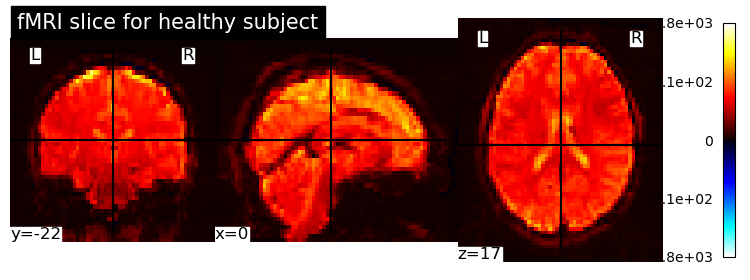

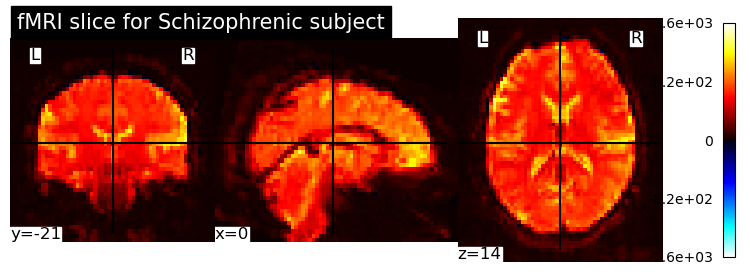

In [5]:
# example subject
sub = healthy_ids[0] # sub-0001

# functional image
fmri = nib.load(data_path+sub+'/func/'+sub+'_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

# anatomical image
anat = nib.load(data_path+sub+'/anat/'+sub+'_desc-preproc_T1w.nii.gz')

confounds = pd.read_csv(data_path+sub+'/func/'+sub+'_task-rest_run-1_desc-confounds_timeseries.tsv', sep = '\t')
#print(confounds)
global_signal = confounds.global_signal.values # common signal that is regresse out

# the anatomical image is larger (the functional image is lower resolution than the anatomical)
print('functional image shape:', fmri.shape) # x, y, z and time
print('anatomical image shape:', anat.shape)

# resolution is in header (last dimension is "tr = time resolution": in seconds)
print('functional image resolution:', fmri.header.get_zooms())
print('anatomical image resolution:', anat.header.get_zooms())

# vieweing anatomical image 
# nplt.view_img(anat, threshold=100, vmax=500, cmpa='gray', bg_img=None, symmetric_cmap=False)
# or simply (without all the specifications)
# nplt.plot_anat(anat)

# viewing functional image
# healthy sub
sub =  healthy_ids[0] # sub-0001
fmri = nib.load(data_path+sub+'/func/'+sub+'_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
nplt.plot_stat_map(ni.image.index_img(fmri,0), title='fMRI slice for healthy subject')

# schizo sub
sub = schizo_ids[0] # sub-0089
fmri = nib.load(data_path+sub+'/func/'+sub+'_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
nplt.plot_stat_map(ni.image.index_img(fmri,0), title='fMRI slice for Schizophrenic subject')

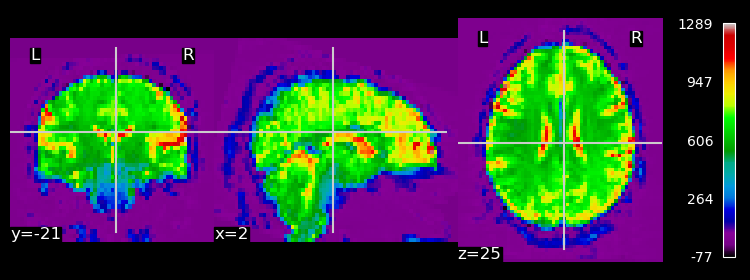

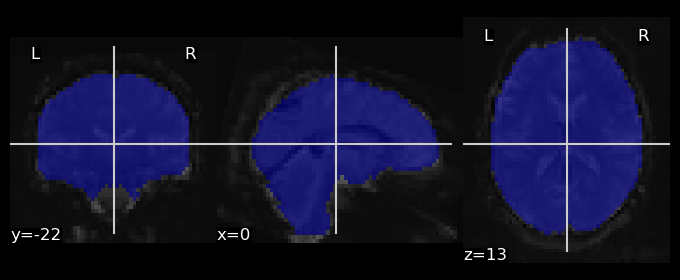

In [6]:
# Visualize mean fmri
mean_fmri = ni.image.image.mean_img(fmri)
nplt.plot_epi(mean_fmri, colorbar=True, cbar_tick_format="%i")

# Visualize it as an ROI
mask_fmri = ni.masking.compute_epi_mask(fmri)
nplt.plot_roi(mask_fmri, mean_fmri)

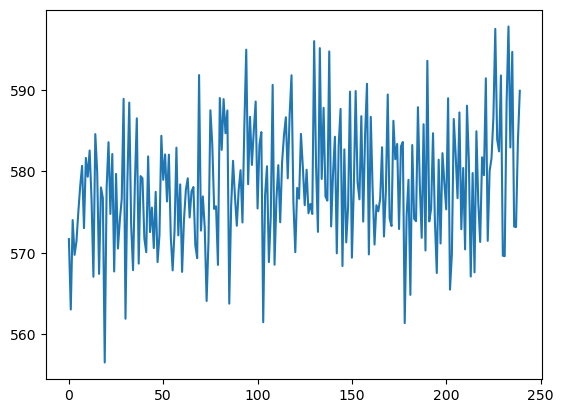

In [7]:
plt.plot(fmri.dataobj[20,20,24,:]) #time series for voxel x=20,y=20,z=24

(240, 40217)


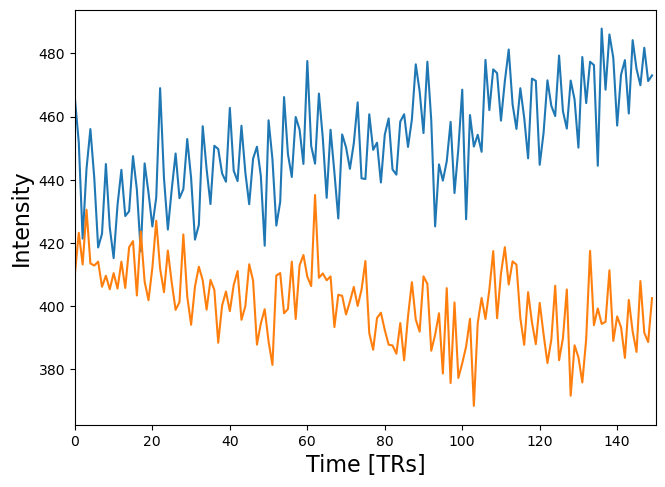

In [8]:
masked_data = ni.masking.apply_mask(fmri, mask_fmri)
print(masked_data.shape)

# masked_data shape is (timepoints, voxels). We can plot the first 150
# timepoints from two voxels
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:150, :2])
plt.xlabel("Time [TRs]", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=0.12, top=0.95, right=0.95, left=0.12)

nplt.show()

In [9]:
# if we want to acquire all of the data, then we can use the following (which casts the data to 64-bit float)):
y = fmri.get_fdata() # the other function fmri.dataobj is not a real array

[NiftiLabelsMasker.fit] loading data from /zhome/8a/1/127380/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('/work3/khma/SRPBS_OPEN/BIDS/derivs/fmriprep/sub-0089/func/sub-0089_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
time series shape: (240, 100)


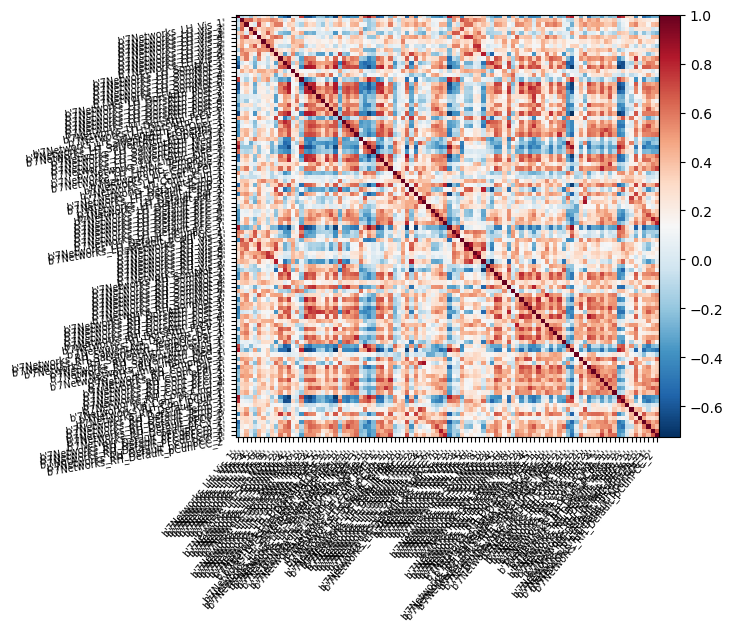

In [10]:
# Using an atlas
schaefer = ni.datasets.fetch_atlas_schaefer_2018(n_rois=100) # default n_rois = 400
maps = schaefer.maps
labels = schaefer.labels

# create masker using MultiNiftiLabelsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# computation
masker = NiftiLabelsMasker(maps, standardize=True, verbose=5, detrend=True) # error if using memory='nilearn_cache'

# OBS should we use: standardize="zscore_sample"?
masker.fit(fmri)

#https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
time_series = masker.transform(fmri, confounds=global_signal) # parse coundfounds = whatever signal we try to regress out. The correlation tends to be reduced by regressing out(removing) more confounds 
# global signals = overall average signal
print('time series shape:', time_series.shape)
#plt.plot(time_series)

# connectivity measure 
conn = ni.connectome.ConnectivityMeasure(kind='correlation') # just setting up the estimator
corr_mat = conn.fit_transform([time_series]) # correlation matrix
nplt.plot_matrix(corr_mat[0], labels=labels)

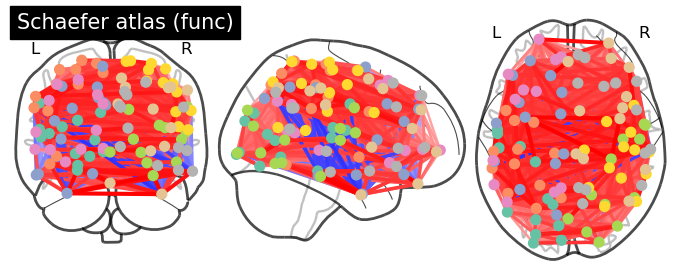

In [11]:
# reference: https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_atlas_comparison.html#sphx-glr-auto-examples-03-connectivity-plot-atlas-comparison-py

# Mean correlation matrix across 10 subjects can be grabbed like this using connectome measure object
mean_corr_mat = conn.mean_

# get atlas coordinates
coordinates = nplt.find_parcellation_cut_coords(labels_img=maps)

# plot connectome with 80% edge strength in the connectivity
nplt.plot_connectome(
    mean_corr_mat,
    coordinates,
    edge_threshold="50%",
    title="Schaefer atlas (func)",
)

# or interactive plot
view = nplt.view_connectome(corr_mat[0], coordinates, edge_threshold='50%')
view

### 1.2 Graphs

In [12]:
example_sub = 0 #  example subject (we just use the first one)
dataset = 'decnef' # 'hcp' or 'decnef'

#### Different thresholds (threshold annealing)

Number of nonzero elements:


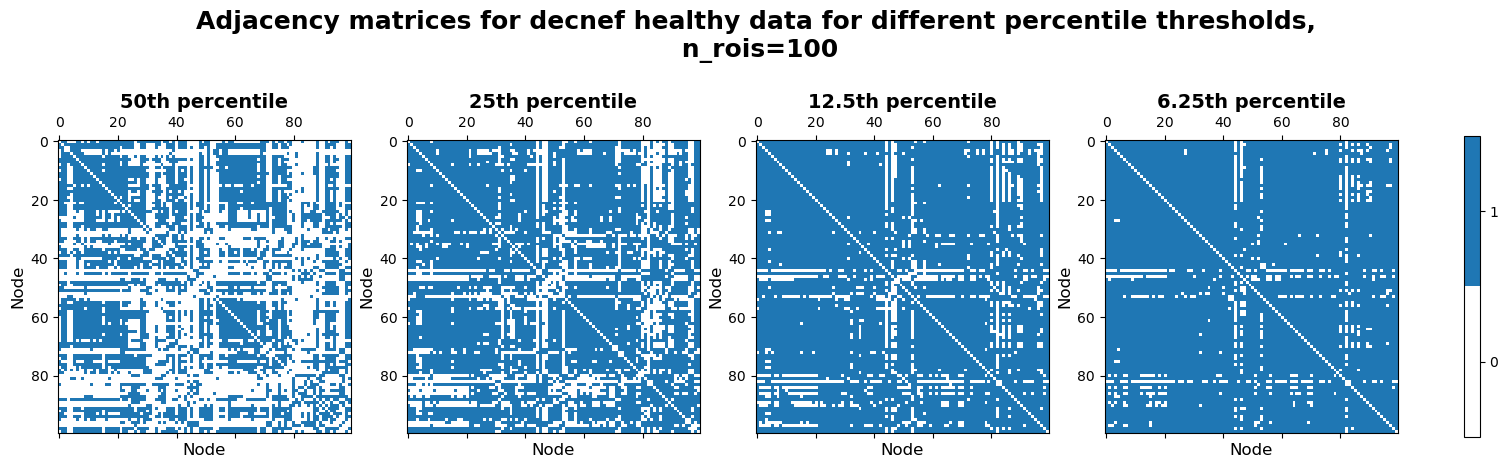

In [13]:
atlas_name = 'schaefer'
n_rois = 100 # 100, 200 or 300
data_folder_name = atlas_name+str(n_rois)
folder_path = os.path.join(main_dir, 'data/'+dataset+'/'+data_folder_name)

# compute A
A1_vals_list = np.load(os.path.join(folder_path,'A1_vals_list.npy'))
A1 = compute_A(A1_vals_list, n_rois)
A2_vals_list = np.load(os.path.join(folder_path,'A2_vals_list.npy'))
A2 = compute_A(A2_vals_list, n_rois)
A3_vals_list = np.load(os.path.join(folder_path,'A3_vals_list.npy'))
A3 = compute_A(A3_vals_list, n_rois)
A4_vals_list = np.load(os.path.join(folder_path,'A4_vals_list.npy'))
A4 = compute_A(A4_vals_list, n_rois)

# showing the four different graphs for a single subject
default_blue = '#1f77b4'
cmap_binary = ListedColormap(['white', default_blue]) 

fig, axs = plt.subplots(1,4, figsize=(15, 5), constrained_layout=True)
axs = axs.ravel()
im = axs[0].spy(A1[:,:,example_sub], cmap=cmap_binary)#marker='.', markersize=3)
axs[0].set_title('50th percentile', fontsize=subtitle_fontsize, weight='bold')
axs[0].set_ylabel('Node', fontsize=label_fontsize)
axs[0].set_xlabel('Node', fontsize=label_fontsize)

axs[1].spy(A2[:,:,example_sub], cmap=cmap_binary) #marker='.', markersize=3)
axs[1].set_title('25th percentile', fontsize = subtitle_fontsize, weight='bold')
axs[1].set_ylabel('Node', fontsize=label_fontsize)
axs[1].set_xlabel('Node', fontsize=label_fontsize)

axs[2].spy(A3[:,:,example_sub], cmap=cmap_binary) #marker='.', markersize=3)
axs[2].set_title('12.5th percentile', fontsize = subtitle_fontsize, weight='bold')
axs[2].set_ylabel('Node', fontsize=label_fontsize)
axs[2].set_xlabel('Node', fontsize=label_fontsize)

axs[3].spy(A4[:,:,example_sub], cmap=cmap_binary) #marker='.', markersize=3)
axs[3].set_title('6.25th percentile', fontsize = subtitle_fontsize, weight='bold')
axs[3].set_ylabel('Node', fontsize=label_fontsize)
axs[3].set_xlabel('Node', fontsize=label_fontsize)

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.7)

print('Number of nonzero elements:')
(A1[:,:,example_sub] > 0).sum(), (A2[:,:,example_sub] > 0).sum(), (A3[:,:,example_sub] > 0).sum(), (A4[:,:,example_sub] > 0).sum()
if dataset=='hcp':   
    fig.suptitle('Adjacency matrices for ' + dataset + ' functional data for different percentile thresholds,\n n_rois='+str(n_rois), fontsize=title_fontsize, weight='bold')
else:
    fig.suptitle('Adjacency matrices for ' + dataset + ' healthy data for different percentile thresholds,\n n_rois='+str(n_rois), fontsize=title_fontsize, weight='bold')
plt.savefig(main_dir+'/figures/'+dataset+'_data_anneal.png', bbox_inches='tight')

#### Different resolutions

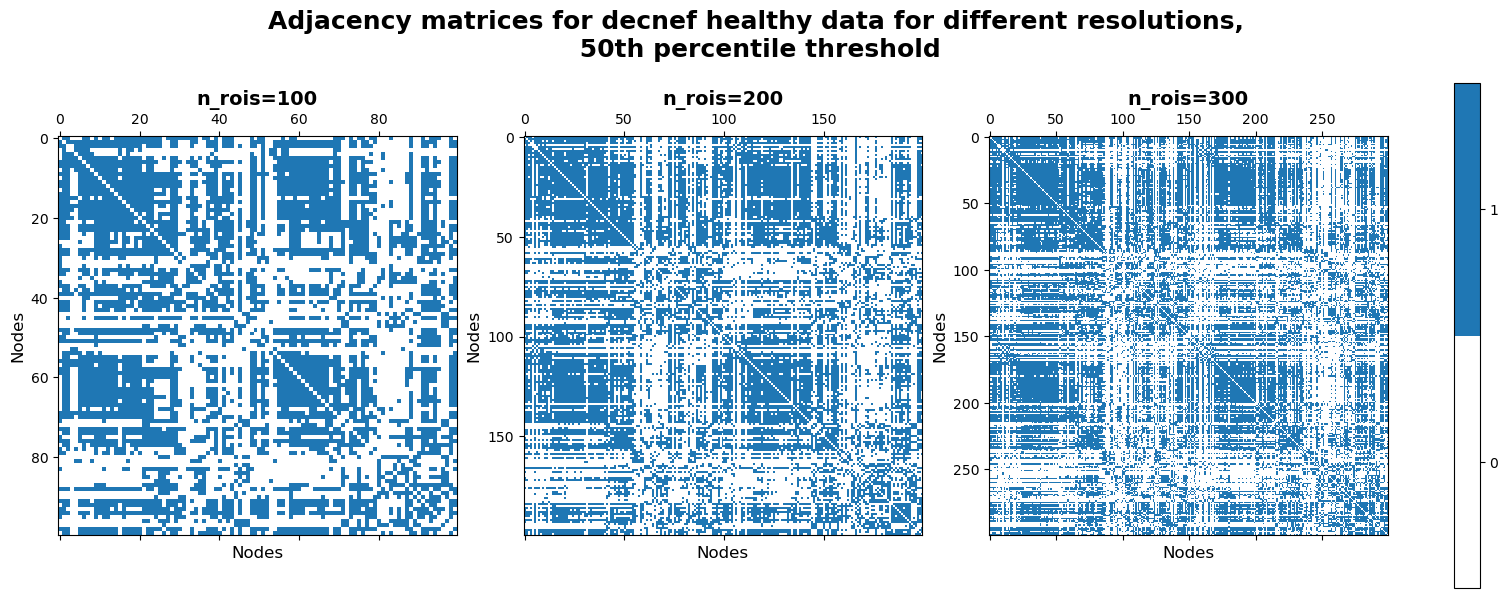

In [14]:
n_rois = 100 # 100, 200 or 300

# compute A
A1_100_vals_list = np.load(os.path.join(main_dir, 'data/'+dataset+'/'+atlas_name+'100/A1_vals_list.npy'))
A1_100 = compute_A(A1_100_vals_list, n_rois=100)

A1_200_vals_list = np.load(os.path.join(main_dir, 'data/'+dataset+'/'+atlas_name+'200/A1_vals_list.npy'))
A1_200 = compute_A(A1_200_vals_list, n_rois=200)

A1_300_vals_list = np.load(os.path.join(main_dir, 'data/'+dataset+'/'+atlas_name+'300/A1_vals_list.npy'))
A1_300 = compute_A(A1_300_vals_list, n_rois=300)

fig, axs = plt.subplots(1,3, figsize=(15, 6), constrained_layout=True)
axs = axs.ravel()

default_blue = '#1f77b4'
cmap_binary = ListedColormap(['white', default_blue]) 

im = axs[0].spy(A1_100[:,:,example_sub], cmap=cmap_binary)
axs[0].set_ylabel('Nodes',fontsize=label_fontsize)
axs[0].set_xlabel('Nodes',fontsize=label_fontsize)
axs[0].set_title('n_rois=100', fontsize=subtitle_fontsize, weight='bold')

im = axs[1].spy(A1_200[:,:,example_sub], cmap=cmap_binary)
axs[1].set_ylabel('Nodes',fontsize=label_fontsize)
axs[1].set_xlabel('Nodes',fontsize=label_fontsize)
axs[1].set_title('n_rois=200',fontsize=subtitle_fontsize, weight='bold')

im = axs[2].spy(A1_300[:,:,example_sub], cmap=cmap_binary)
axs[2].set_ylabel('Nodes', fontsize=label_fontsize)
axs[2].set_xlabel('Nodes', fontsize=label_fontsize)
axs[2].set_title('n_rois=300', fontsize=subtitle_fontsize, weight='bold')
 
if dataset=='hcp':   
    fig.suptitle('Adjacency matrices for ' + dataset + ' functional data for different resolutions,\n 50th percentile threshold', fontsize=title_fontsize, weight='bold')
else:
    fig.suptitle('Adjacency matrices for ' + dataset + ' healthy data for different resolutions,\n 50th percentile threshold', fontsize=title_fontsize, weight='bold')
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig(main_dir+'/figures/'+dataset+'_data_nrois.png', bbox_inches='tight')

#### Different graph types

In [15]:
healthy_ids[:5]

array(['sub-0001', 'sub-0002', 'sub-0003', 'sub-0004', 'sub-0005'],
      dtype=object)

In [16]:
schizo_ids[:5]

array(['sub-0089', 'sub-0090', 'sub-0091', 'sub-0092', 'sub-0093'],
      dtype=object)

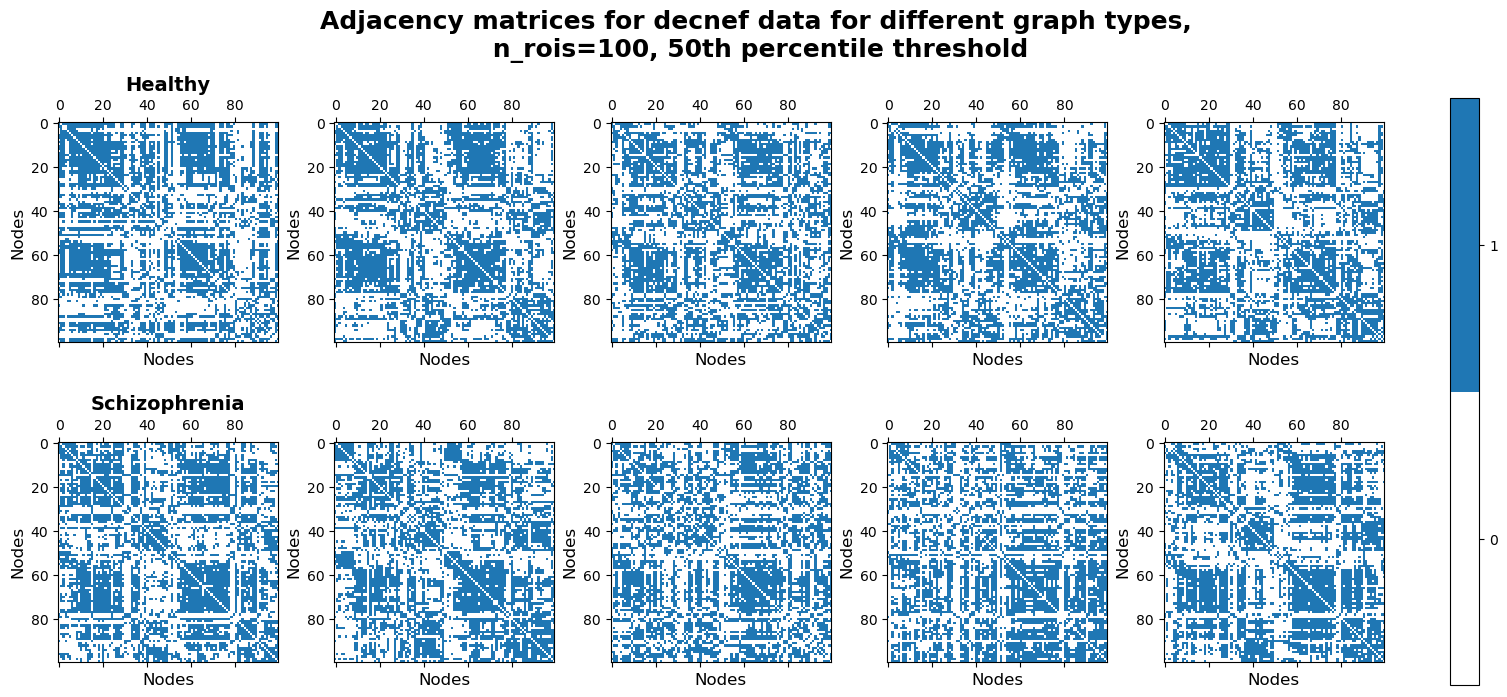

In [17]:
n_rois = 100 # 100, 200 or 300
data_folder_name = atlas_name+str(n_rois)
folder_path = os.path.join(main_dir, 'data/'+dataset+'/'+data_folder_name)

# compute A
A_vals_list = np.load(os.path.join(folder_path,'A1_vals_list.npy'))
A = compute_A(A_vals_list, n_rois)

if dataset == 'hcp':
    A_type1 = A[:,:,:250] # fmri
    A_type2 = A[:,:,250:] # dmri
else: #dataset == 'decnef'
    healthy_mask = np.load(main_dir+'/data/'+dataset+'/healthy_mask.npy')
    schizo_mask = np.load(main_dir+'/data/'+dataset+'/schizo_mask.npy')
    A_type1 = A[:,:,healthy_mask] # healthy
    A_type2 = A[:,:,schizo_mask] # schizo

fig, axs = plt.subplots(2, 5, figsize=(15, 7), constrained_layout=True)
#fig.subplots_adjust(top=0.9)  # Add space between suptitle and subplots
#fig.subplots_adjust(hspace=0.6)  # Add space between the first 5 subplots and the last 5 subplots

axs = axs.ravel()

default_blue = '#1f77b4'
cmap_binary = ListedColormap(['white', default_blue]) 

for s in range(10):
    if s < 5:
        im = axs[s].spy(A_type1[:,:,s], cmap=cmap_binary)
        #if dataset=='hcp':
        #    axs[s].set_title('Functional: '+str(s+1), fontsize=subtitle_fontsize, weight='bold')
        #else:
        #    axs[s].set_title('Healthy: '+str(s+1), fontsize=subtitle_fontsize, weight='bold')
        axs[s].set_ylabel('Nodes', fontsize=label_fontsize)
        axs[s].set_xlabel('Nodes', fontsize=label_fontsize)
    else:
        im = axs[s].spy(A_type2[:,:,-(s-4)], cmap=cmap_binary)
        #if dataset=='hcp':
        #    axs[s].set_title('Structural: '+str(s-4), fontsize=subtitle_fontsize, weight='bold')
        #else:
        #    axs[s].set_title('Schizo: '+str(s-4), fontsize=subtitle_fontsize, weight='bold')
        axs[s].set_ylabel('Nodes', fontsize=label_fontsize)
        axs[s].set_xlabel('Nodes', fontsize=label_fontsize)

if dataset=='hcp':
    axs[0].set_title('Functional', fontsize=subtitle_fontsize, weight='bold')
    axs[5].set_title('Structural', fontsize=subtitle_fontsize, weight='bold')
else: 
    axs[0].set_title('Healthy', fontsize=subtitle_fontsize, weight='bold')
    axs[5].set_title('Schizophrenia', fontsize=subtitle_fontsize, weight='bold')
    
fig.suptitle('Adjacency matrices for ' + dataset + ' data for different graph types,\n n_rois='+str(n_rois)+', 50th percentile threshold', fontsize=title_fontsize, weight='bold')
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig(main_dir+'/figures/'+dataset+'_data_types.png', bbox_inches='tight')

In [18]:
#import plotly.express as px
#px.imshow(A0[:,:,sub_id])

## 2. mSBM results

2.1. Partition

- Partition matrix
- Brain map according to the partition

2.2 Cluster-link probability ($\eta$)
- $\eta$ matrices
- $\eta$ as circular graphs

2.3 Log posterior probability

Plotting notes:
- plot using rank (wrt. y-axis) on x-axis

In [19]:
main_dir = os.getcwd()
df = pd.read_csv(os.path.join(main_dir, 'results', 'experiment_overview.csv'), header=0, sep=',', converters={'n_rois': literal_eval,
                                                                                                        'exp_name_list': literal_eval,
                                                                                                        'N': literal_eval,
                                                                                                        'K': literal_eval,
                                                                                                        'S1': literal_eval,
                                                                                                        'S2': literal_eval})

In [20]:
df

dataset atlas_name  n_rois threshold_annealing     model_type  \
0          hcp   schaefer   100.0               False     parametric   
1          hcp   schaefer   100.0               False     parametric   
2          hcp   schaefer   200.0               False     parametric   
3          hcp   schaefer   300.0               False     parametric   
4          hcp   schaefer   100.0               False     parametric   
..         ...        ...     ...                 ...            ...   
315  synthetic       None     NaN                None  nonparametric   
316  synthetic       None     NaN                None  nonparametric   
317  synthetic       None     NaN                None     parametric   
318  synthetic       None     NaN                None     parametric   
319  synthetic       None     NaN                None     parametric   

     splitmerge  noc  maxiter_gibbs  maxiter_eta0  maxiter_alpha  \
0         False   10           1000            10            100   
1         False   20           1000            10            100   
2         False   50           1000            10            100   
3         False   40           1000            10            100   
4         False   50           1000            10            100   
..          ...  ...            ...           ...            ...   
315        True   20            100            10            100   
316        True    5            100            10            100   
317       False    5            100            10            100   
318       False    2            100            10            100   
319       False    5            100            10            100   

    matlab_compare      N     K    S1   S2     Nc_type eta_similarity  \
0             None    NaN   NaN   NaN  NaN        None           None   
1             None    NaN   NaN   NaN  NaN        None           None   
2             None    NaN   NaN   NaN  NaN        None           None   
3             None    NaN   NaN   NaN  NaN        None           None   
4             None    NaN   NaN   NaN  NaN        None           None   
..             ...    ...   ...   ...  ...         ...            ...   
315          False  100.0   5.0  10.0  5.0  unbalanced           same   
316          False  100.0  10.0   5.0  5.0  unbalanced      comp_diff   
317          False  100.0  10.0   5.0  5.0    balanced      comp_diff   
318          False  100.0   5.0  10.0  5.0    balanced           same   
319          False  100.0   2.0   5.0  5.0  unbalanced      comp_diff   

                                         exp_name_list  n_exp  
0    [parametric_schaefer100_2023-05-10 14:59:03.98...     10  
1    [parametric_schaefer100_2023-05-09 20:52:42.64...     10  
2    [parametric_schaefer200_2023-05-10 12:32:50.65...     10  
3    [parametric_schaefer300_2023-05-10 10:24:56.75...     10  
4    [parametric_schaefer100_2023-05-10 04:48:52.29...     10  
..                                                 ...    ...  
315  [nonparametric_5_10_5_unbalanced_same_2023-05-...     10  
316  [nonparametric_10_5_5_unbalanced_comp_diff_202...      9  
317  [parametric_10_5_5_balanced_comp_diff_2023-05-...     10  
318  [parametric_5_10_5_balanced_same_2023-05-23 11...     10  
319  [parametric_2_5_5_unbalanced_comp_diff_2023-05...     10  

[320 rows x 19 columns]

In [21]:
dataset = 'hcp' # 'hcp', 'decnef' or 'synthetic'
# sort by dataset
if dataset == 'hcp' or dataset == 'decnef':
    df_dataset = df.loc[df.dataset==dataset].sort_values(by=['n_rois','threshold_annealing','model_type','splitmerge','noc'], ascending=True).reset_index()
elif dataset == 'synthetic':
    df_dataset = df.loc[df.dataset==dataset].sort_values(by=['N','K','S1','S2','Nc_type', 'eta_similarity', 'model_type','splitmerge','noc'], ascending=True).reset_index()
else:
    print('unknown dataset')

In [22]:
df_dataset

index dataset atlas_name  n_rois threshold_annealing     model_type  \
0       0     hcp   schaefer   100.0               False     parametric   
1       1     hcp   schaefer   100.0               False     parametric   
2      12     hcp   schaefer   100.0               False     parametric   
3      15     hcp   schaefer   100.0               False     parametric   
4       4     hcp   schaefer   100.0               False     parametric   
5      13     hcp   schaefer   100.0                True  nonparametric   
6       9     hcp   schaefer   200.0               False     parametric   
7       8     hcp   schaefer   200.0               False     parametric   
8      14     hcp   schaefer   200.0               False     parametric   
9       5     hcp   schaefer   200.0               False     parametric   
10      2     hcp   schaefer   200.0               False     parametric   
11      6     hcp   schaefer   300.0               False     parametric   
12      7     hcp   schaefer   300.0               False     parametric   
13     11     hcp   schaefer   300.0               False     parametric   
14      3     hcp   schaefer   300.0               False     parametric   
15     10     hcp   schaefer   300.0               False     parametric   

    splitmerge  noc  maxiter_gibbs  maxiter_eta0  maxiter_alpha  \
0        False   10           1000            10            100   
1        False   20           1000            10            100   
2        False   30           1000            10            100   
3        False   40           1000            10            100   
4        False   50           1000            10            100   
5         True   30            400            10            100   
6        False   10           1000            10            100   
7        False   20           1000            10            100   
8        False   30           1000            10            100   
9        False   40           1000            10            100   
10       False   50           1000            10            100   
11       False   10           1000            10            100   
12       False   20           1000            10            100   
13       False   30           1000            10            100   
14       False   40           1000            10            100   
15       False   50           1000            10            100   

   matlab_compare   N   K  S1  S2 Nc_type eta_similarity  \
0            None NaN NaN NaN NaN    None           None   
1            None NaN NaN NaN NaN    None           None   
2            None NaN NaN NaN NaN    None           None   
3            None NaN NaN NaN NaN    None           None   
4            None NaN NaN NaN NaN    None           None   
5            None NaN NaN NaN NaN    None           None   
6            None NaN NaN NaN NaN    None           None   
7            None NaN NaN NaN NaN    None           None   
8            None NaN NaN NaN NaN    None           None   
9            None NaN NaN NaN NaN    None           None   
10           None NaN NaN NaN NaN    None           None   
11           None NaN NaN NaN NaN    None           None   
12           None NaN NaN NaN NaN    None           None   
13           None NaN NaN NaN NaN    None           None   
14           None NaN NaN NaN NaN    None           None   
15           None NaN NaN NaN NaN    None           None   

                                        exp_name_list  n_exp  
0   [parametric_schaefer100_2023-05-10 14:59:03.98...     10  
1   [parametric_schaefer100_2023-05-09 20:52:42.64...     10  
2   [parametric_schaefer100_2023-05-09 21:28:47.73...     10  
3   [parametric_schaefer100_2023-05-10 09:41:13.54...     10  
4   [parametric_schaefer100_2023-05-10 04:48:52.29...     10  
5   [nonparametric_schaefer100_2023-05-10 20:45:53...     20  
6   [parametric_schaefer200_2023-05-10 07:17:44.76...     10  
7   [parametric_schaefer200_2023-05-09 20:52:42.65...     10  


In [23]:
exp1_folders = df_dataset.exp_name_list[5]
exp2_folders = df_dataset.exp_name_list[2]

exp1_paths = [os.path.join(main_dir,'results/'+dataset+'/'+folder) for folder in exp1_folders]
exp2_paths = [os.path.join(main_dir,'results/'+dataset+'/'+folder) for folder in exp2_folders]

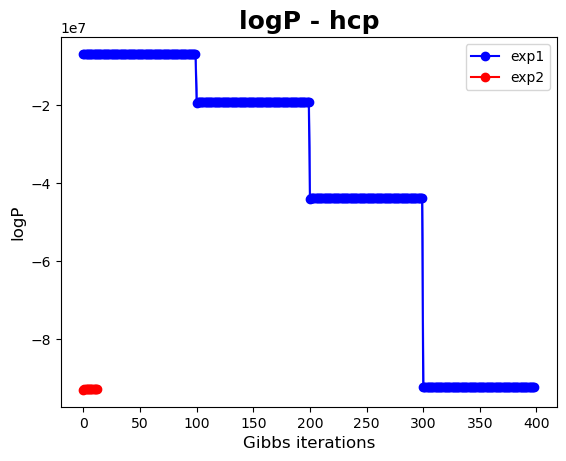

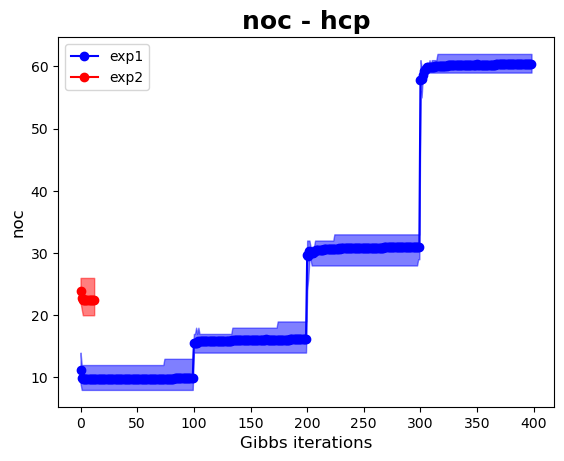

In [24]:
exp1_folders = df_dataset.exp_name_list[5] # nonparametric
exp2_folders = df_dataset.exp_name_list[2] # parametric

old_plot_par(dataset, exp1_folders, exp2_folders, par='logP', plot1=True, plot2=True, miniter_gibbs=None, maxiter_gibbs=None)
old_plot_par(dataset, exp1_folders, exp2_folders, par='noc', plot1=True, plot2=True, miniter_gibbs=None, maxiter_gibbs=None)
#old_plot_par(dataset, exp1_folders, exp2_folders, par='logP', plot1=True, plot2=False)
#old_plot_par(dataset, exp1_folders, exp2_folders, par='logP', plot1=False, plot2=True)

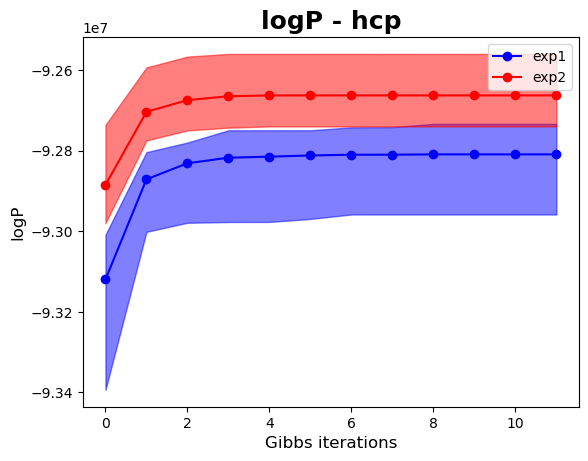

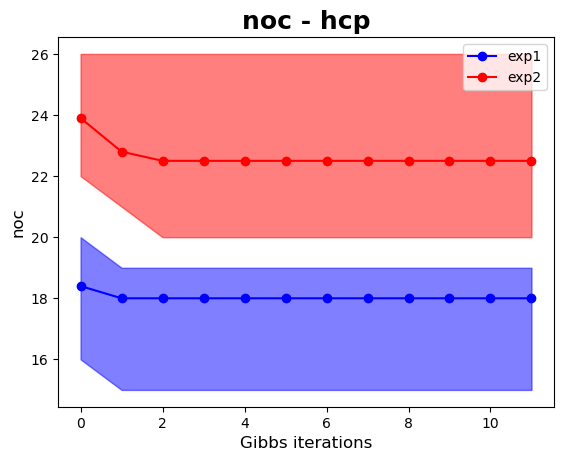

In [25]:
exp1_folders = df_dataset.exp_name_list[1] # parametric (noc=20)
exp2_folders = df_dataset.exp_name_list[2] # parametric (noc=30)
old_plot_par(dataset, exp1_folders, exp2_folders, par='logP', plot1=True, plot2=True)
old_plot_par(dataset, exp1_folders, exp2_folders, par='noc', plot1=True, plot2=True)


In [26]:
#oldold_plot_par(dataset, exp1_folders, exp2_folders, par='noc', plot1=True, plot2=True)
#oldold_plot_par(dataset, exp1_folders, exp2_folders, par='noc', plot1=True, plot2=False)
#oldold_plot_par(dataset, exp1_folders, exp2_folders, par='noc', plot1=False, plot2=True)

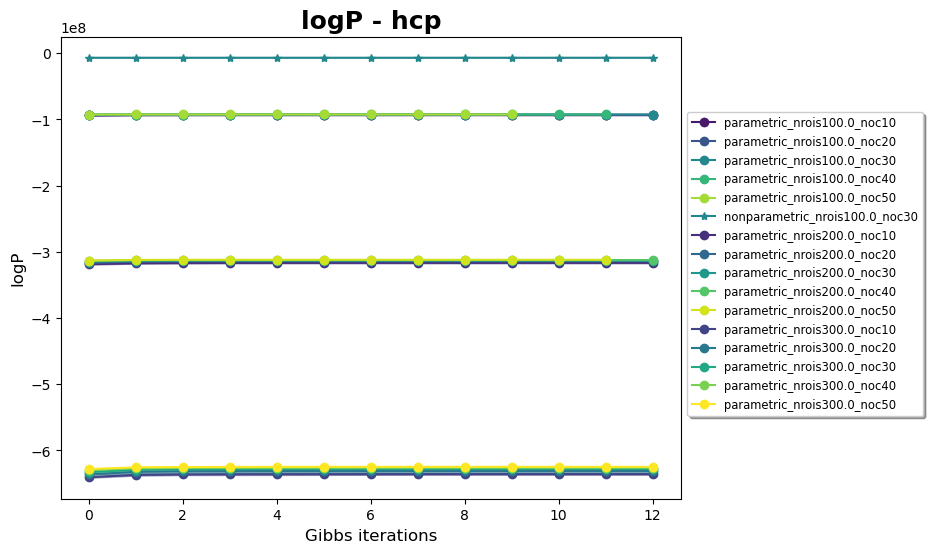

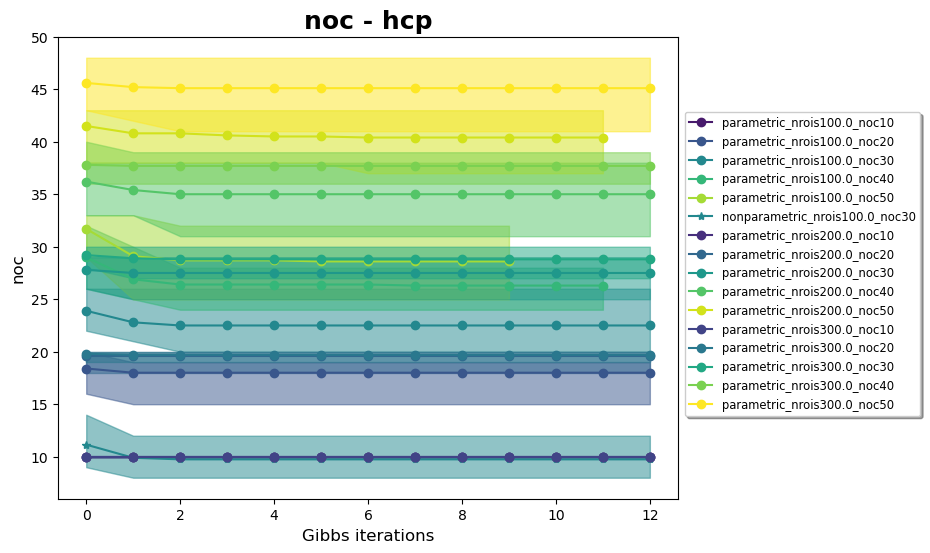

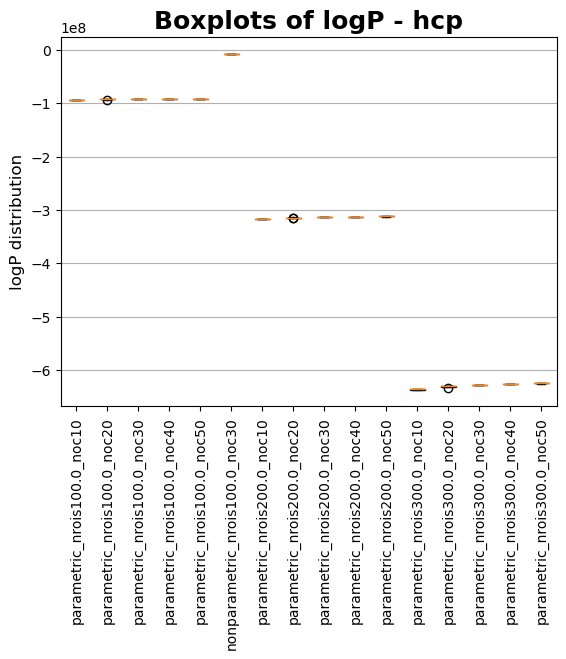

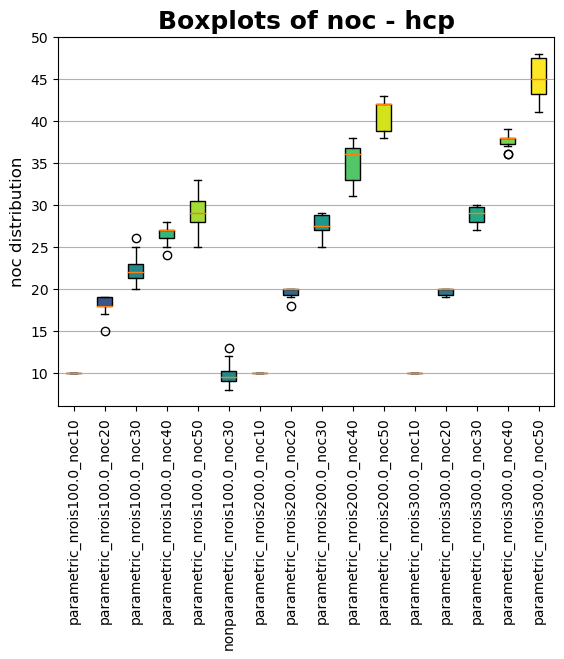

In [27]:
plot_par(dataset=dataset, df=df, par='logP', miniter_gibbs=None, maxiter_gibbs=None)
plot_par(dataset=dataset, df=df, par='noc', miniter_gibbs=None, maxiter_gibbs=None)

boxplot_par(dataset=dataset, df=df, par='logP')
boxplot_par(dataset=dataset, df=df, par='noc')

In [28]:
# limiting df to plot wrt nrois and only parametric models (hopefully better visuals)
df_par_nrois100 = df.loc[(df.n_rois==100) & (df.model_type=='parametric')]
df_par_nrois200 = df.loc[(df.n_rois==200) & (df.model_type=='parametric')]
df_par_nrois300 = df.loc[(df.n_rois==300) & (df.model_type=='parametric')]

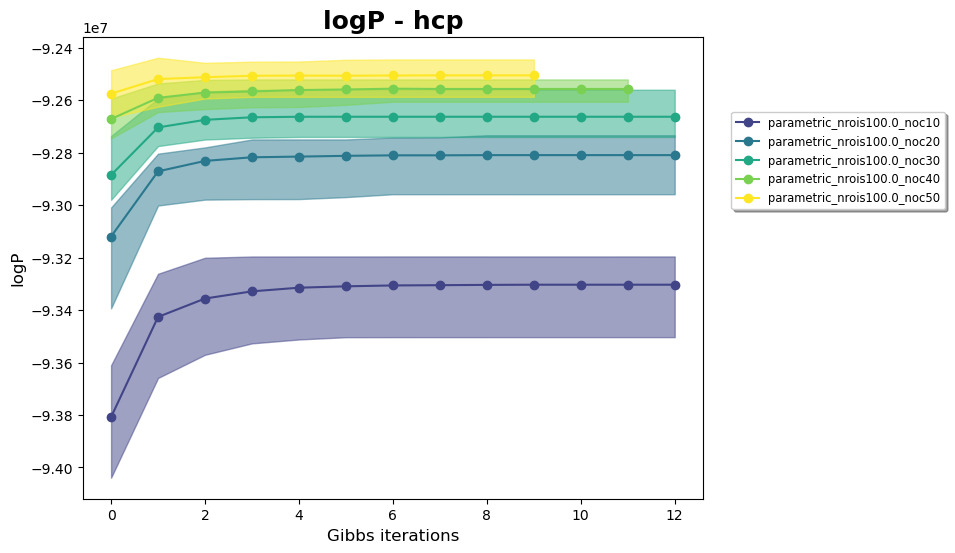

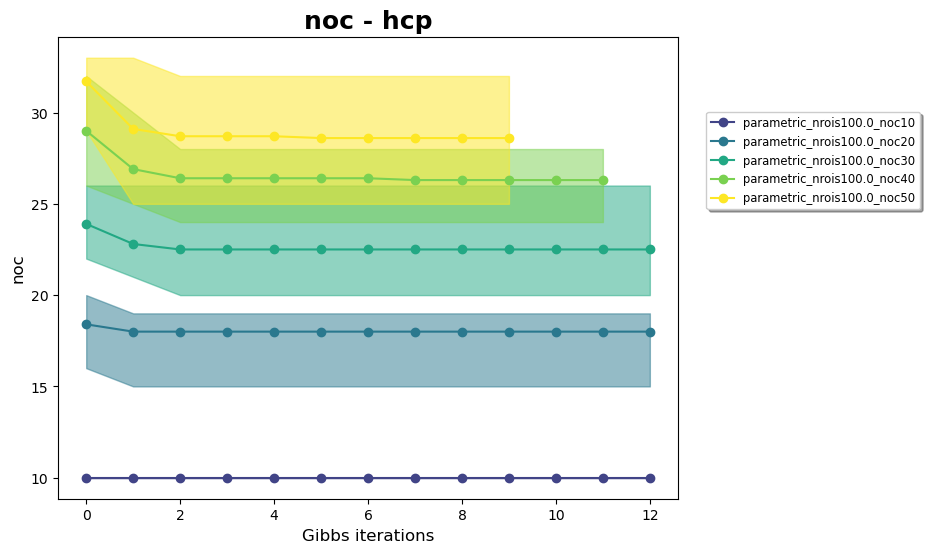

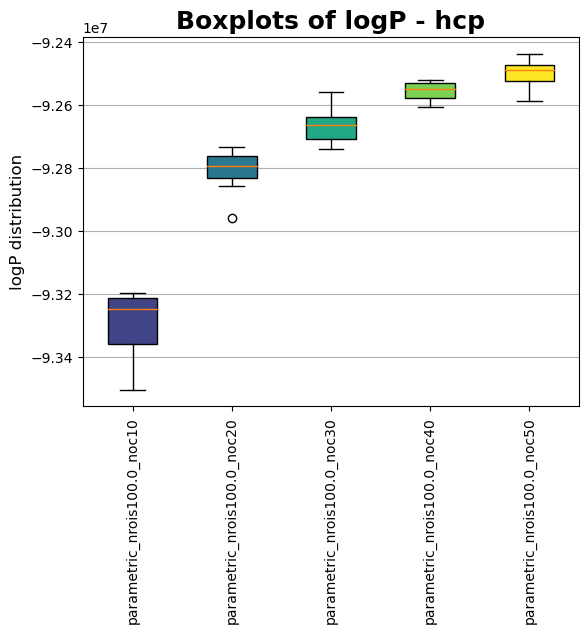

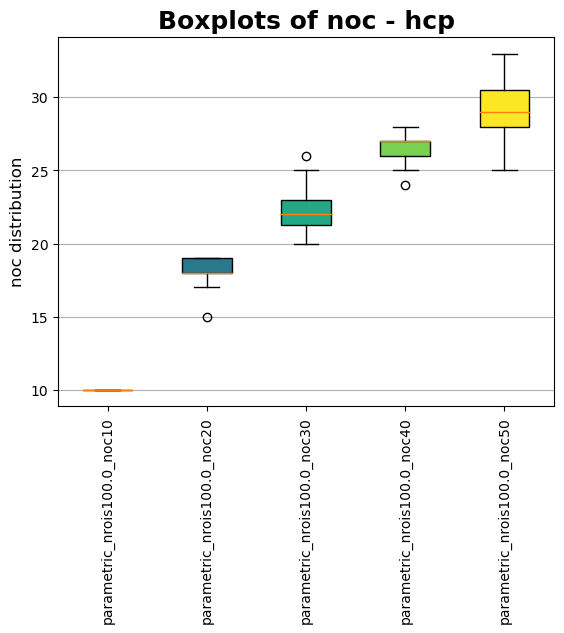

In [29]:
plot_par(dataset=dataset, df=df_par_nrois100, par='logP', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois100_logP')
plot_par(dataset=dataset, df=df_par_nrois100, par='noc', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois100_noc')

boxplot_par(dataset=dataset, df=df_par_nrois100, par='logP', fig_name = 'boxplot_nrois100_logP')
boxplot_par(dataset=dataset, df=df_par_nrois100, par='noc', fig_name = 'boxplot_nrois100_noc')

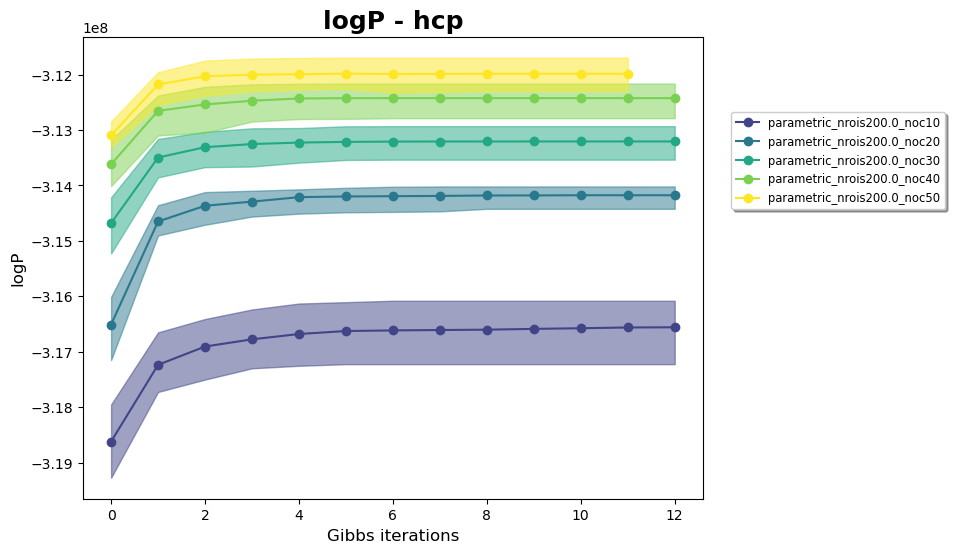

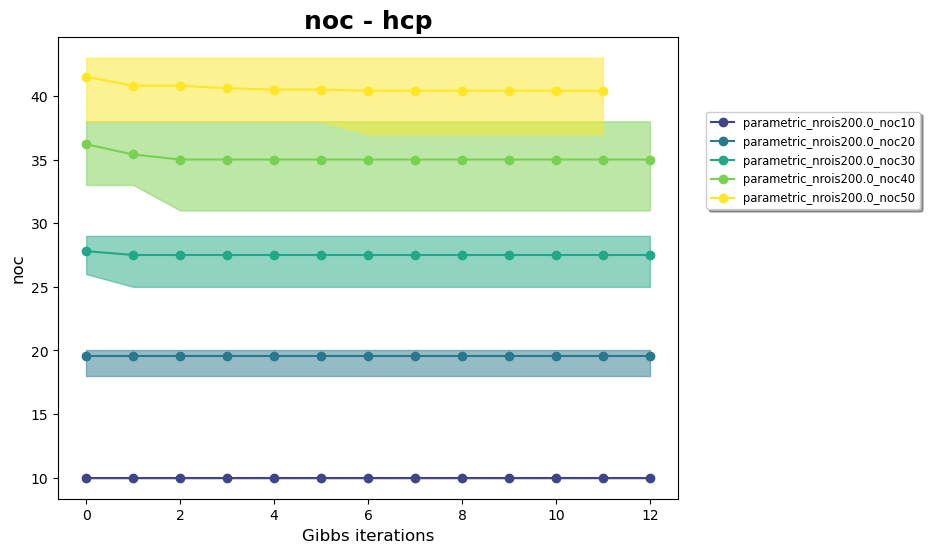

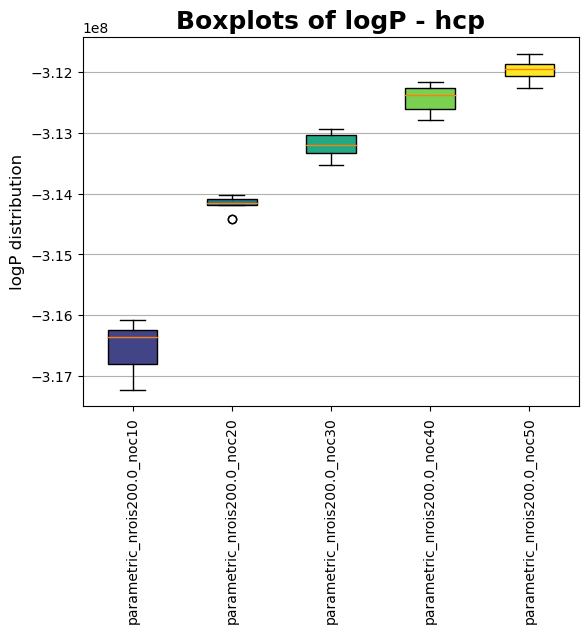

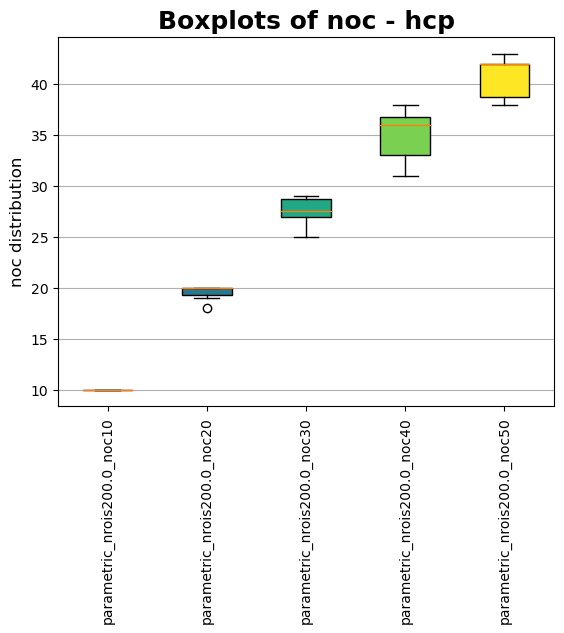

In [30]:
plot_par(dataset=dataset, df=df_par_nrois200, par='logP', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois200_logP')
plot_par(dataset=dataset, df=df_par_nrois200, par='noc', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois200_noc')

boxplot_par(dataset=dataset, df=df_par_nrois200, par='logP', fig_name = 'boxplot_nrois200_logP')
boxplot_par(dataset=dataset, df=df_par_nrois200, par='noc', fig_name = 'boxplot_nrois200_noc')

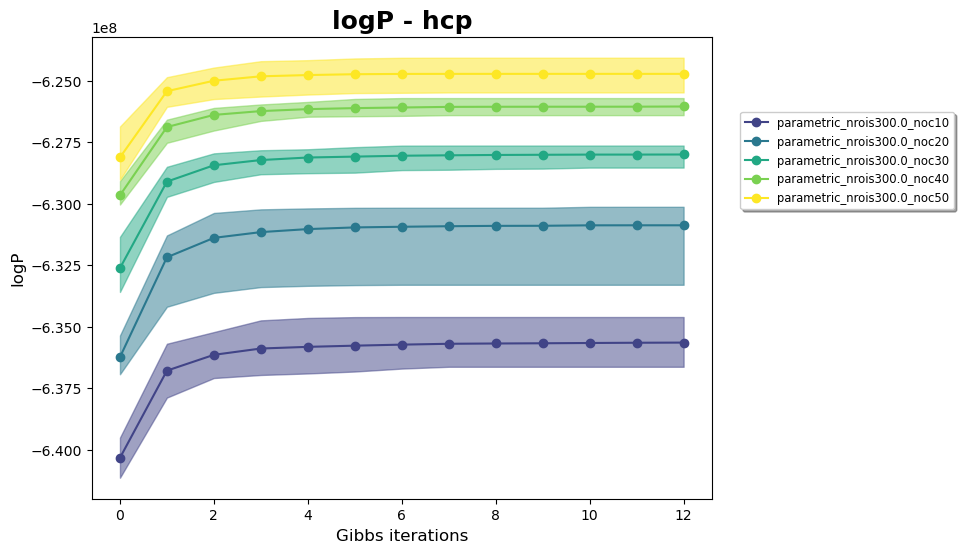

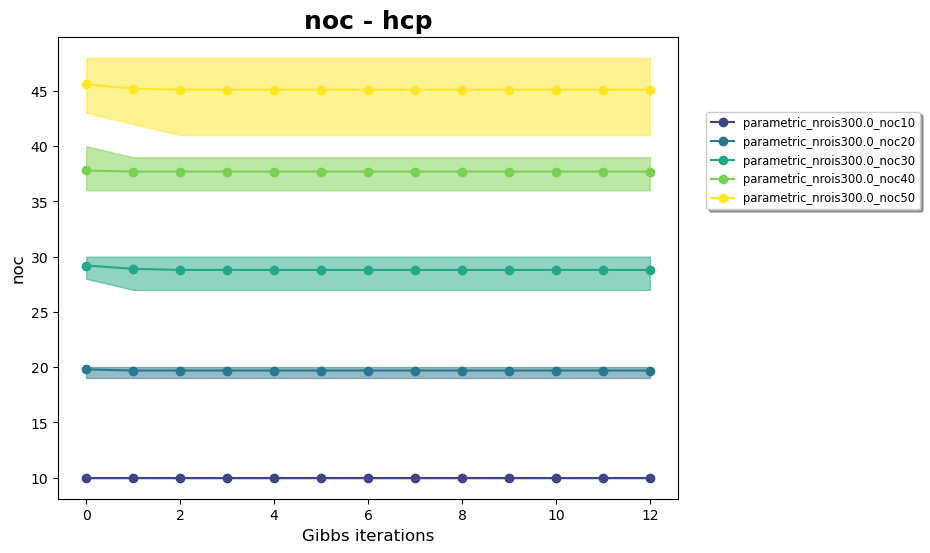

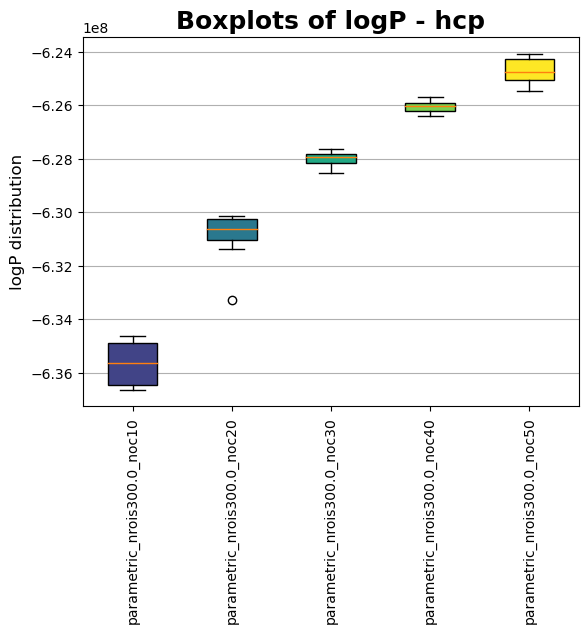

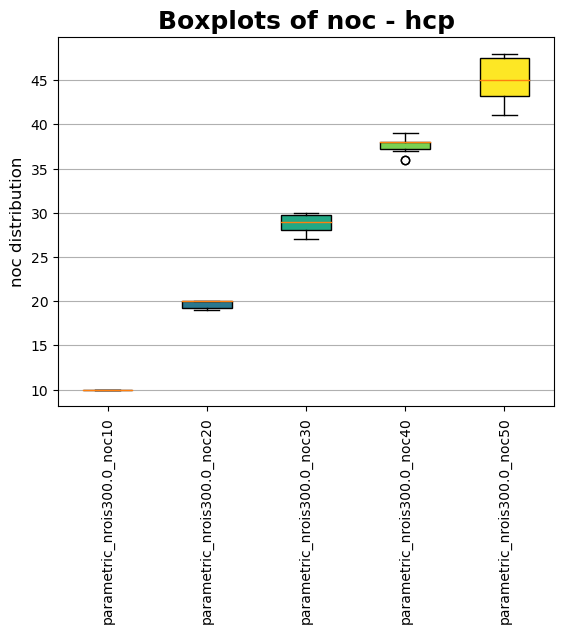

In [31]:
plot_par(dataset=dataset, df=df_par_nrois300, par='logP', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois300_logP')
plot_par(dataset=dataset, df=df_par_nrois300, par='noc', miniter_gibbs=None, maxiter_gibbs=None, fig_name = 'plot_nrois300_noc')

boxplot_par(dataset=dataset, df=df_par_nrois300, par='logP', fig_name = 'boxplot_nrois300_logP')
boxplot_par(dataset=dataset, df=df_par_nrois300, par='noc', fig_name = 'boxplot_nrois300_noc')

In [32]:
# choose experiment to visualize
exp = 0
exp_name = df_dataset.exp_name_list[exp][0] # taking first random initialization
n_rois = int(df_dataset.n_rois[exp])

# extract results
model_sample = np.load(os.path.join(main_dir, 'results/'+dataset+'/'+exp_name+'/model_sample.npy'), allow_pickle=True).item()
model_sample.keys()

dict_keys(['iter', 'Z', 'noc', 'logP_A', 'logP_Z', 'logP', 'eta', 'alpha', 'eta0', 'MAP'])

In [33]:
MAP_sample = model_sample['MAP']

iter = MAP_sample['iter']
Z = MAP_sample['Z']
noc = MAP_sample['noc']
logP_A = MAP_sample['logP_A']
logP_Z = MAP_sample['logP_Z']
logP = MAP_sample['logP']
eta = MAP_sample['eta']
alpha = MAP_sample['alpha']
eta0 = MAP_sample['eta0']

print('MAP logP(Z|A) =', logP)
print('MAP noc =', noc)
print('MAP alpha =', alpha)
#print('eta0 =', eta0)

MAP logP(Z|A) = -93349709.27487238
MAP noc = 10
MAP alpha = 12609353.760402234


Text(0.5, 0, 'subject')

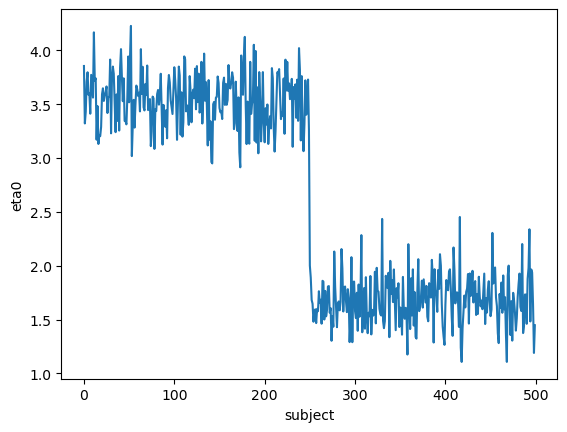

In [34]:
plt.plot(eta0)
plt.ylabel('eta0')
plt.xlabel('subject')
# only shows global differences (over subjects) whereas eta shows local differences (over brain regions)

### Partition Z

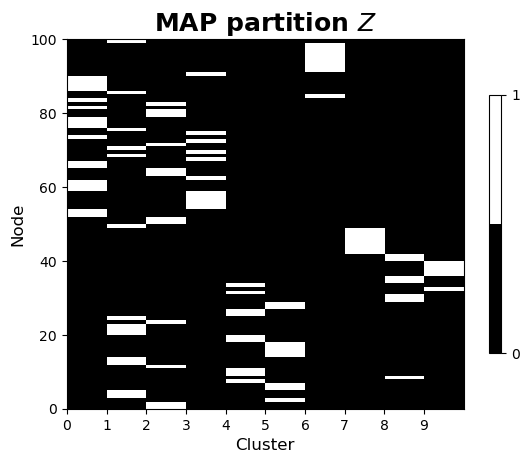

<Figure size 640x480 with 0 Axes>

In [35]:
fig, ax = plt.subplots()
cmap_binary = ListedColormap(['k', 'w']) 
im = ax.imshow(Z.T, interpolation='nearest', aspect='auto', cmap=cmap_binary, extent=(0, Z.shape[0], 0, Z.shape[1]))
ax.set_title('MAP partition $Z$', fontsize=title_fontsize, weight='bold')
plt.xlabel('Cluster', fontsize=label_fontsize)
plt.ylabel('Node', fontsize=label_fontsize)
plt.setp(ax, xticks=range(len(Z)))
cbar = fig.colorbar(im, ax=ax, shrink=0.7, ticks=[0,1])
plt.show()
plt.savefig(main_dir+'/figures/'+dataset+'_Z.png', bbox_inches='tight')  

In [36]:
Z.shape

(10, 100)

In [37]:
Z[-1,:] # no nodes in last cluster for decnef data using nonparametric model?

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Brain map partitioned according to estimated Z

/zhome/8a/1/127380/miniconda3/envs/speciale/lib/python3.9/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



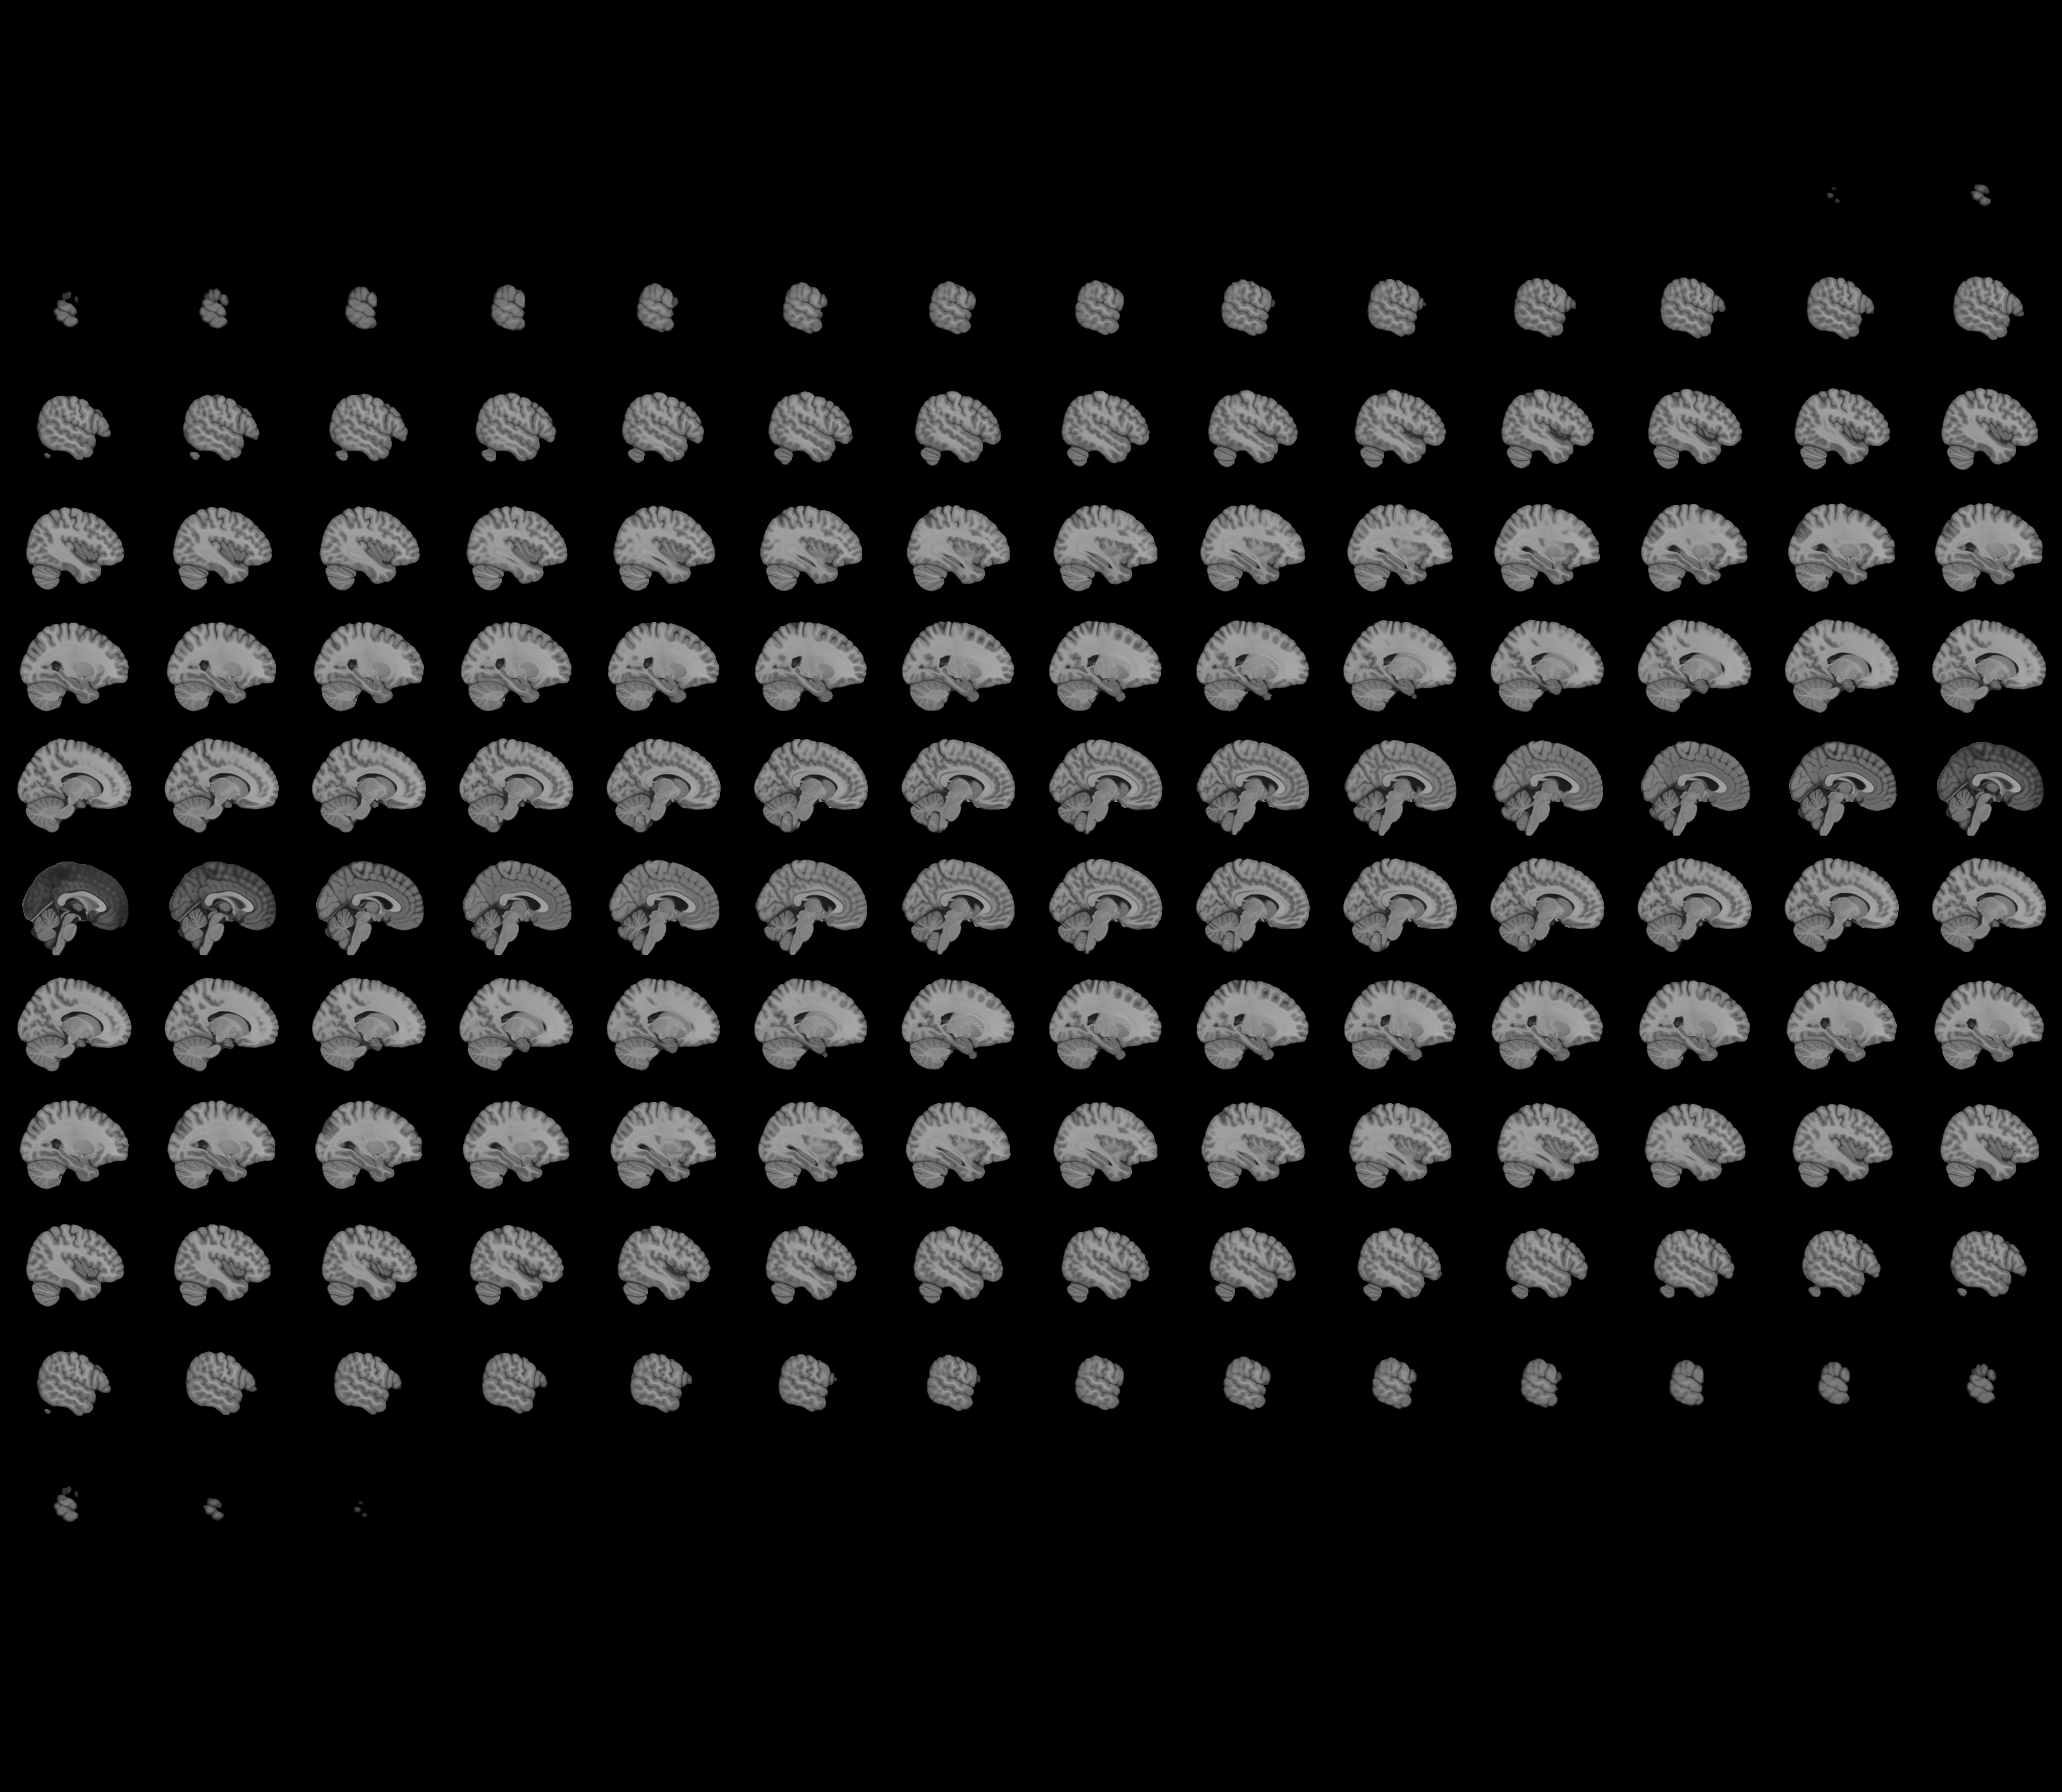
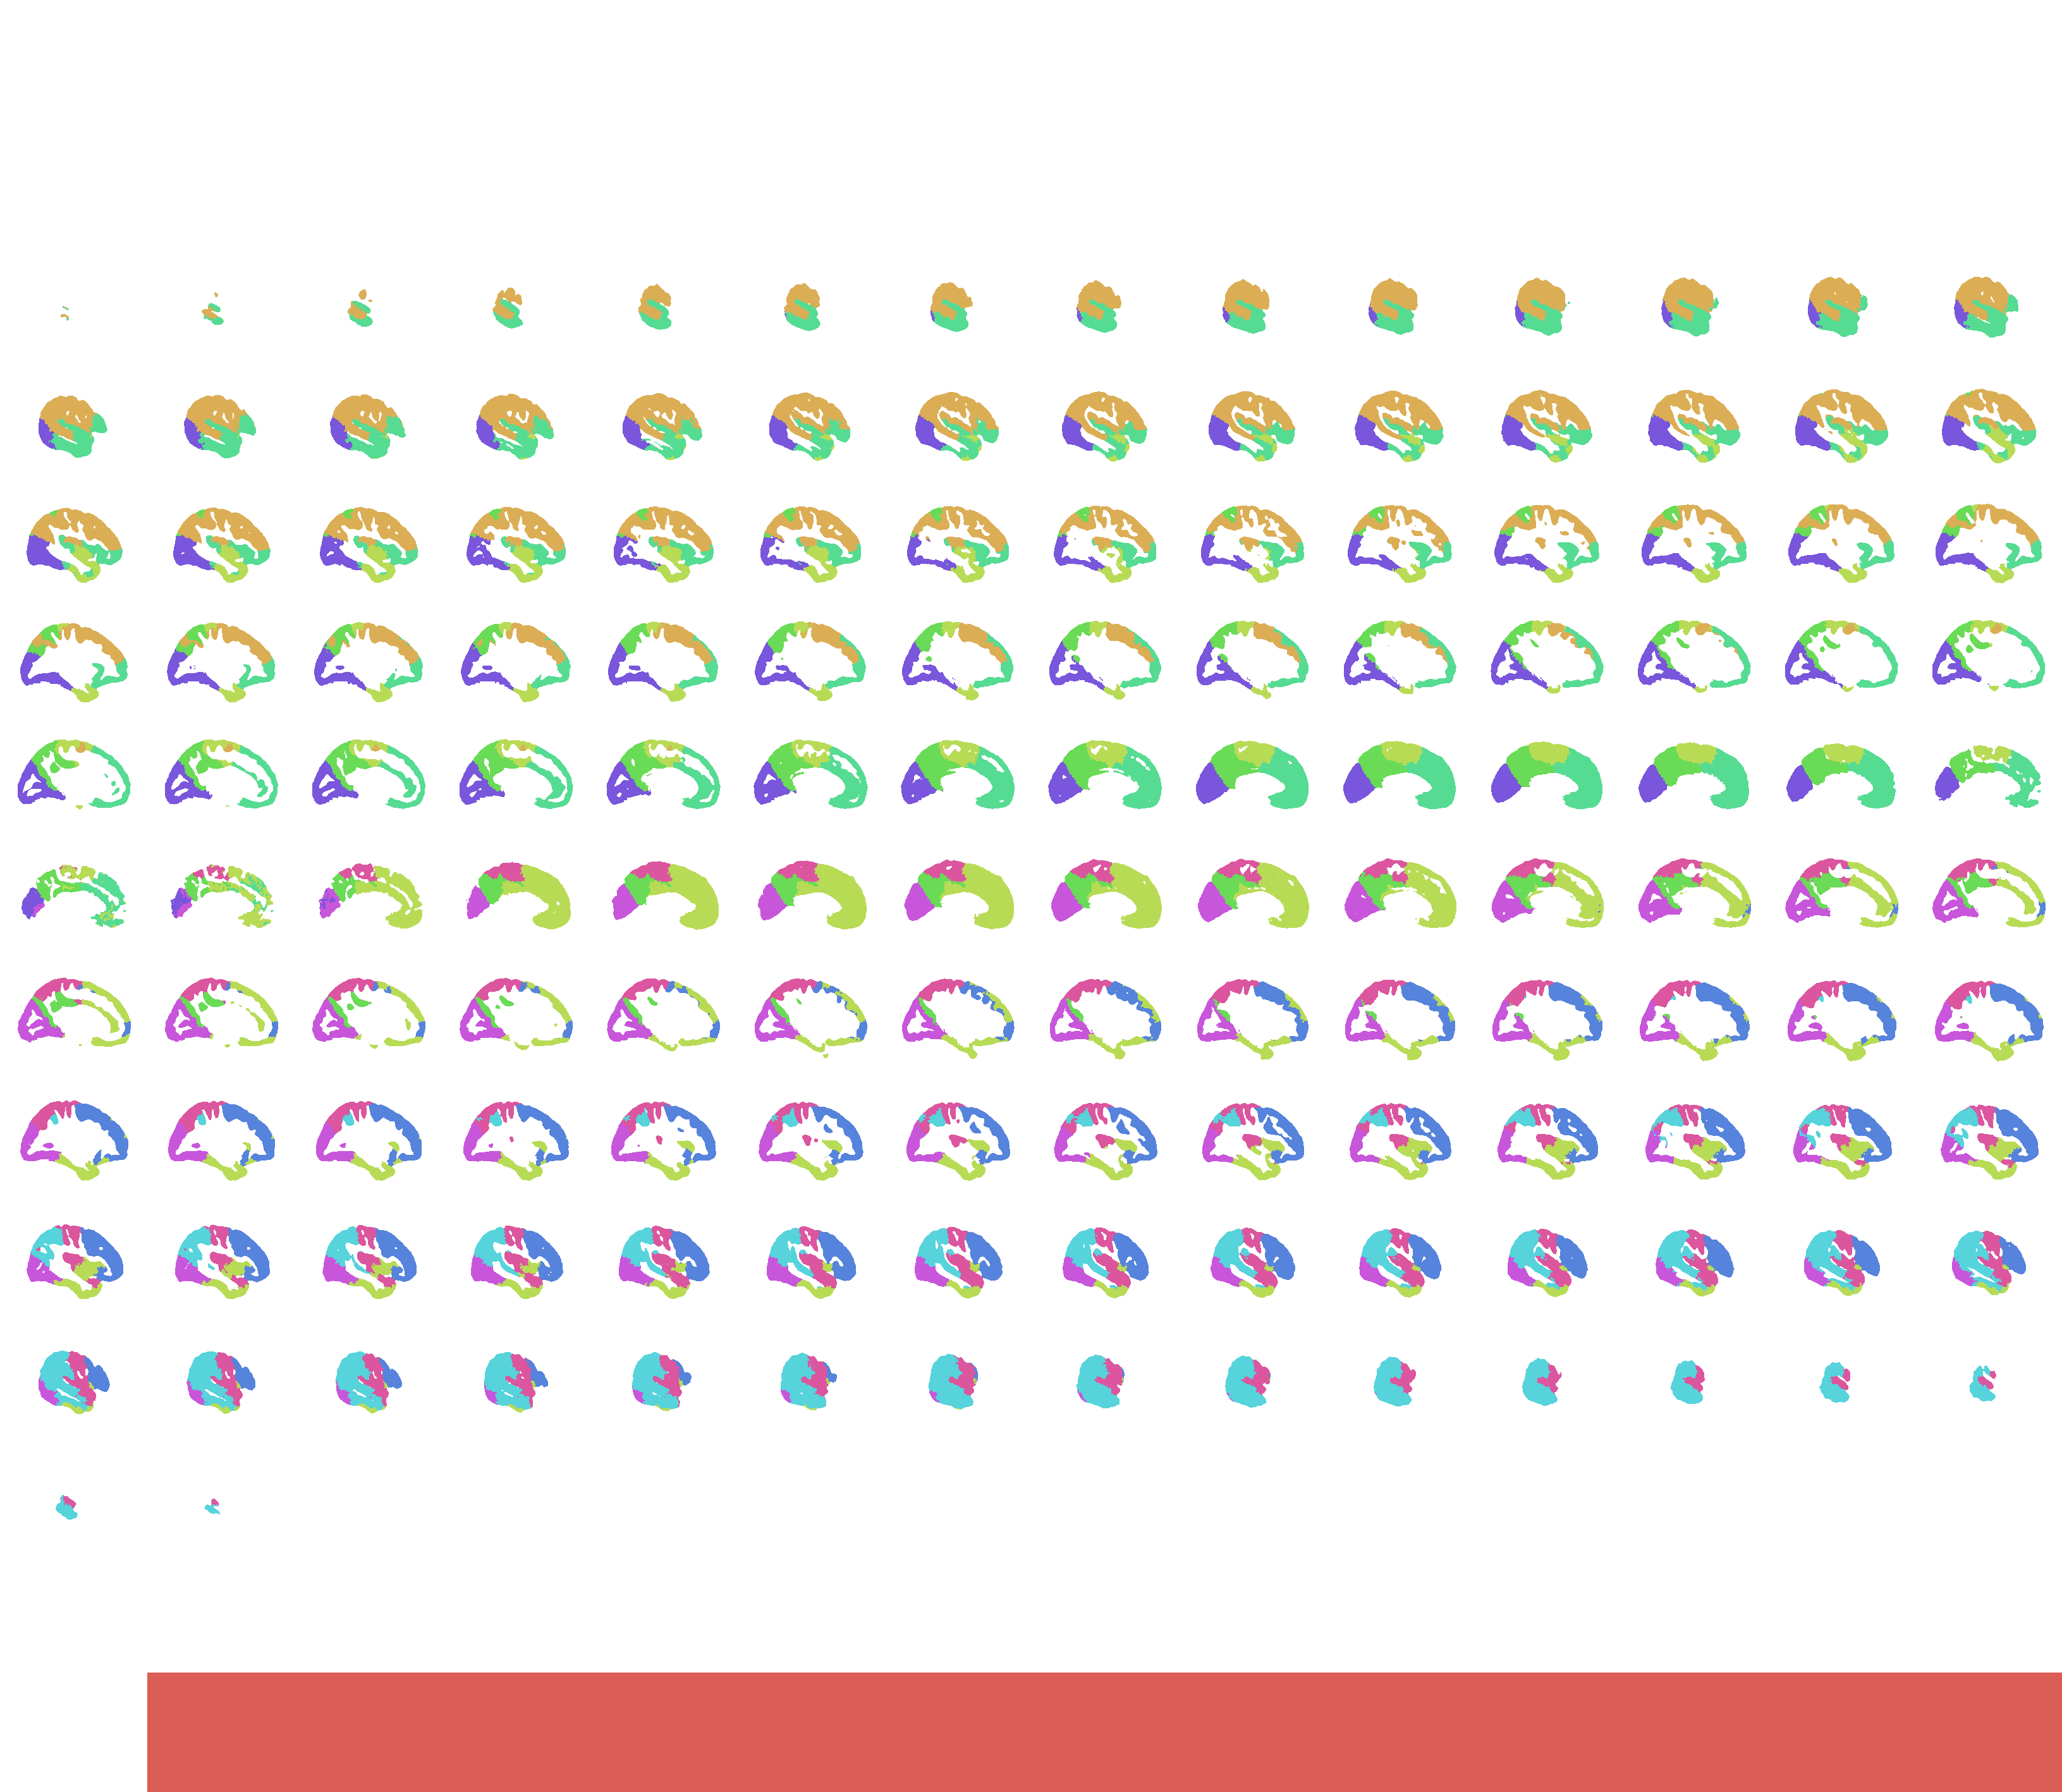

In [38]:
from matplotlib.colors import ListedColormap
# Loading atlas
schaefer = ni.datasets.fetch_atlas_schaefer_2018(n_rois=n_rois) # default n_rois = 400

# extracting map matrix
map = nib.load(schaefer.maps)
map_mat = map.get_fdata() 
# checking that we can map back from numpy to nifti: map_recon = nib.Nifti1Image(map_mat, affine=map.affine)

# replace the values of the atlas with the values of the MAP partition
Zmap_mat = map_mat.copy()
node_labels = np.argmax(Z, axis=0)+1 # label for each node (+1 because the background is 0)
for i in range(1,n_rois+1): # (+1 because the background is 0)
    # note that Zmap_mat==0 is the background
    Zmap_mat[Zmap_mat==i] = node_labels[i-1]

map_ni = nib.Nifti1Image(Zmap_mat, affine=map.affine)
node_colors = sns.color_palette('hls', noc)
cmap_all = ListedColormap(node_colors)
nplt.view_img(map_ni, cmap = cmap_all, symmetric_cmap=False, title='Brain map partition')
#nplt.savefig(main_dir+'/figures/'+dataset+'_brainmap_Z.png', im)

In [39]:
#schaefer.labels

In [40]:
# Prepend background label
schaefer.labels = np.insert(schaefer.labels, 0, 'Background')# Prepend background label
#schaefer.labels

In [41]:
len(schaefer.labels)

101

### Cluster-link probabililties $\eta$

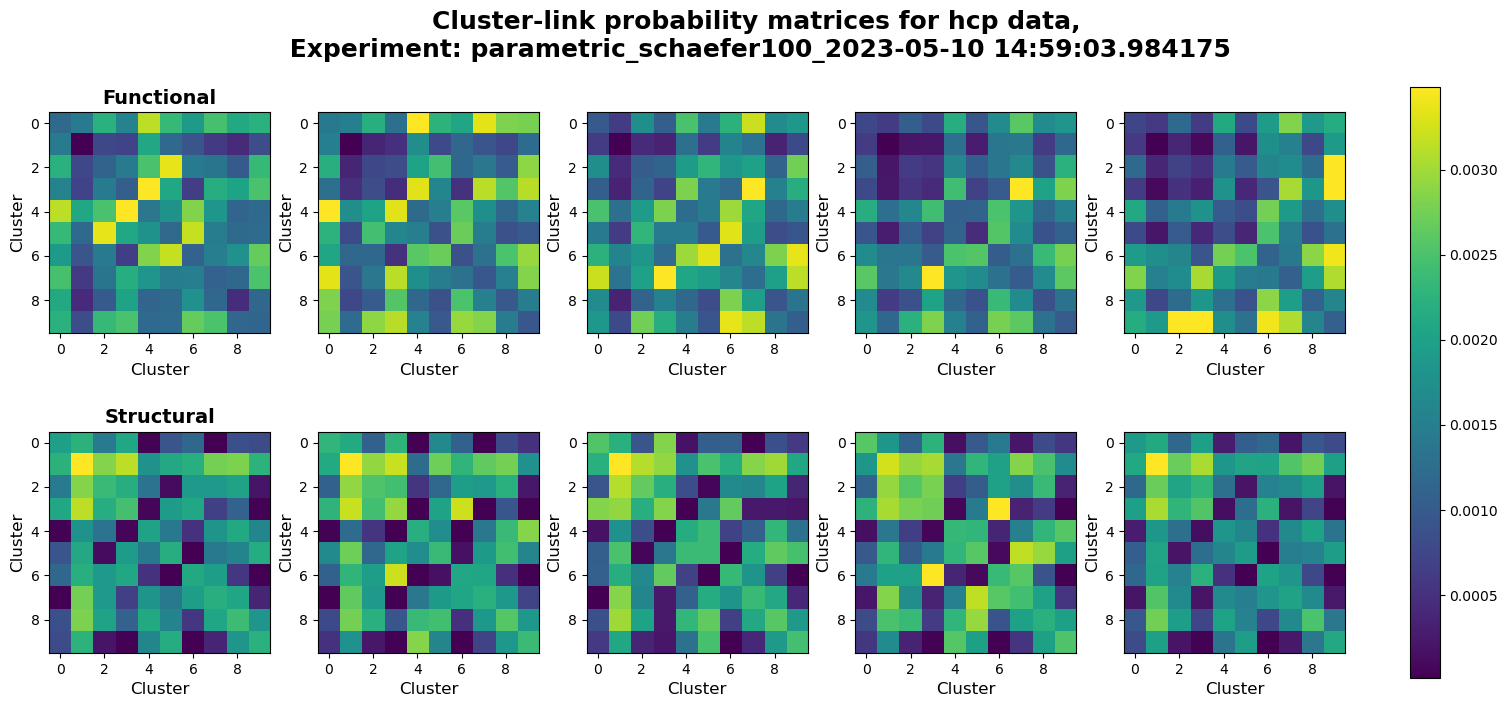

In [42]:
plot_eta(dataset=dataset, eta=eta, exp_name=exp_name, main_dir='/work3/s174162/speciale')

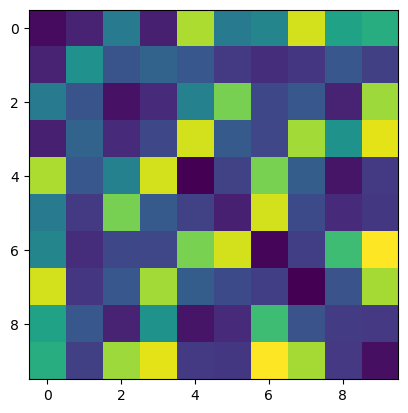

In [43]:
eta_std = np.std(eta, axis=2)
plt.imshow(eta_std)

### Circular graph using networkx

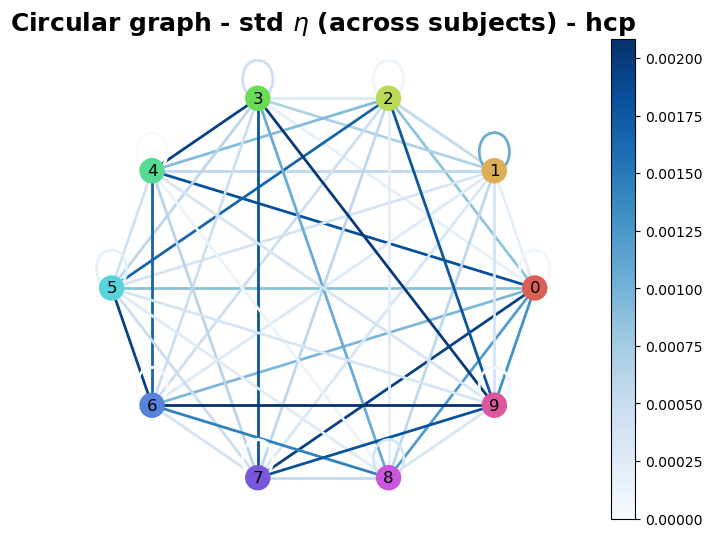

In [44]:
plot_circ_stdeta(dataset=dataset, eta=eta, noc=noc, threshold=0)

Seems weird that prob. of self-link (linking between nodes in the same cluster) is not high in general. We plot the adjacency matrix with nodes sorted according to the partition to see if this is in fact the case. If not, then maybe the diagonal in eta is not computed correctly.


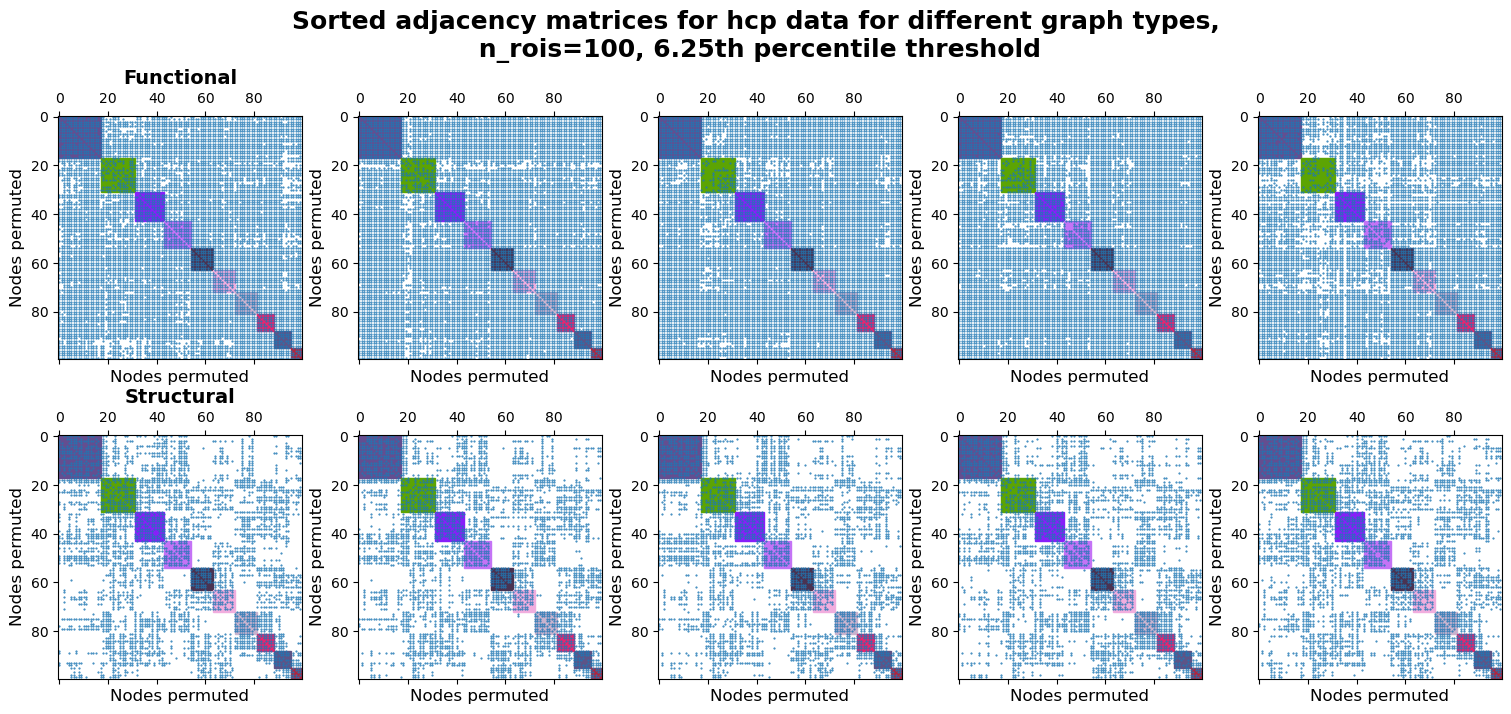

In [45]:
plot_sortedA(Z, dataset, n_rois, atlas_name='schaefer')

### Brain map showing clusters with most different connectivty across population

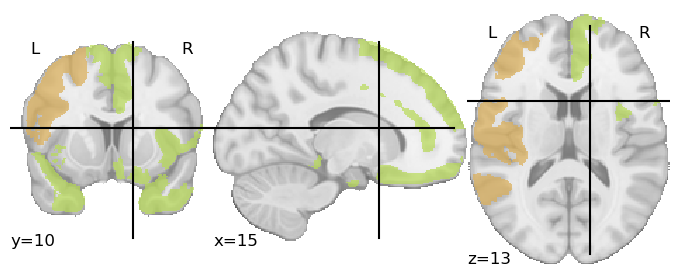

In [46]:
# example
node_color = sns.color_palette('hls', noc)
area1 = 1
area2 = 2
Zmap_mat_areas12 = np.where((Zmap_mat == area1) | (Zmap_mat == area2), Zmap_mat, 0)
map_ni_areas12= nib.Nifti1Image(Zmap_mat_areas12, affine=map.affine)
cmap_areas12 = ListedColormap([node_color[area1], node_color[area2]])
nplt.plot_roi(map_ni_areas12, cmap=cmap_areas12)

# interpretation: the structural and functional connectivity level between the two clusters differs (the functional connectivity between the two areas are significantly higher than the structural connectivity) meaning that the connectivity between the purple and yellow cluster is of different significance wrt. structure and function.

interpretation: the structural and functional connectivity level between the two clusters differs (the functional connectivity between the two areas are significantly higher than the structural connectivity) meaning that the connectivity between the color1 and color2 cluster is of different significance wrt. structure and function.

### Std brain map showing clusters with most different connectivty across population? not sure how to do this

maybe using connectome plotting function??

## 3. Classification 
Inspiration from https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py 

Features: 
- Demographic info
- Correlation matrix (upper triangular excluding diagonal)
- PCA components of correlation matrix?
- Eta
- Eta + demographic info
- (Eta + correlation matrix)?
- (Eta + PCA components)?

Labels/classes (graph types):
- Diagnose (healthy or schizophrenia)
- Sex
- Age

Classifyers:
- LogisticRegression
- RandomForestClassifier
- KNeighborsClassifier
- SVC
- .. ? 

Use 2-layer crossvalidation

We will use the different (combination of) features listed above to distinguish between graph types. We use cross-validation and measure classification accuracy to compare the classifyer performance for each feature type. We use random splits of the subjects into training/testing sets. 

In [47]:
kinds = ['demographic_info', 'correlation', 'pca', 'eta', 'eta+demographic_info', 'eta+correlation', 'eta+pca']

In [48]:
eta.shape

(10, 10, 500)

In [51]:
# reshape to eta to (n_samples, n_features) where n_samples = S and n_features = noc*(noc+1)/2
X = get_X_data(eta) # feature data
print('x_data shape:', X.shape)

# create target/label data: y
if dataset == 'hcp':
    S1 = 250
    S2 = 250
    y = np.concatenate((np.zeros(S1), np.ones(S2)))
elif dataset == 'decnef':
    y = np.load(os.path.join(main_dir, 'data', 'decnef', 'schizo_mask.npy')) # maybe it needs to be 0 and 1 and not False and True
else:
    print('dataset not found')
print('y shape:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_data shape: (500, 55)
y shape: (500,)
X_train shape: (375, 55)
X_test shape: (125, 55)
y_train shape: (375,)
y_test shape: (125,)


### 3.1 Naive classification

In [ ]:
classifier = LogisticRegression() # LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier() or SVC()
classifier.fit(X_train, y_train)

# predict on entire test data
y_pred = classifier.predict(X_test)

# Use score method to get accuracy of model
score = classifier.score(X_test, y_test)
print(score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label', fontsize=label_fontsize)
plt.xlabel('Predicted label', fontsize=label_fontsize)
all_sample_title = 'Accuracy Score: {:.3f}'.format(score)
plt.title(all_sample_title, size = title_fontsize)

It just predicts the majority class. We need to handle the class imbalance problem. Need to tune classifier and use appropiate parameters that allows for generalization

### 3.2 Nested cross-validation with shuffled stratified data-splits in both inner and outer loop

OBS! this is only for one feature-model

Possible soring parameters:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Optimal hyperparameters for the best model (Logistic Regression): {'C': 0.1}


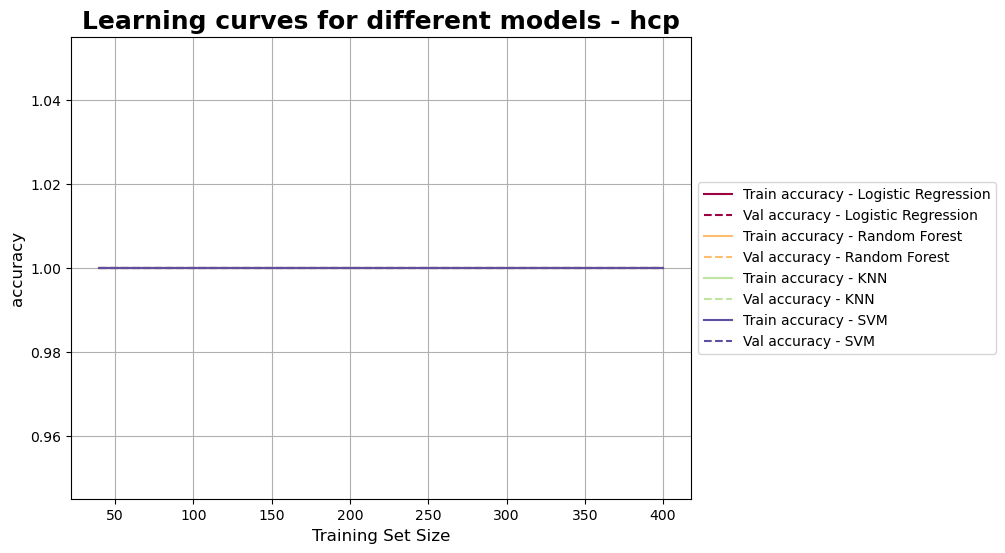

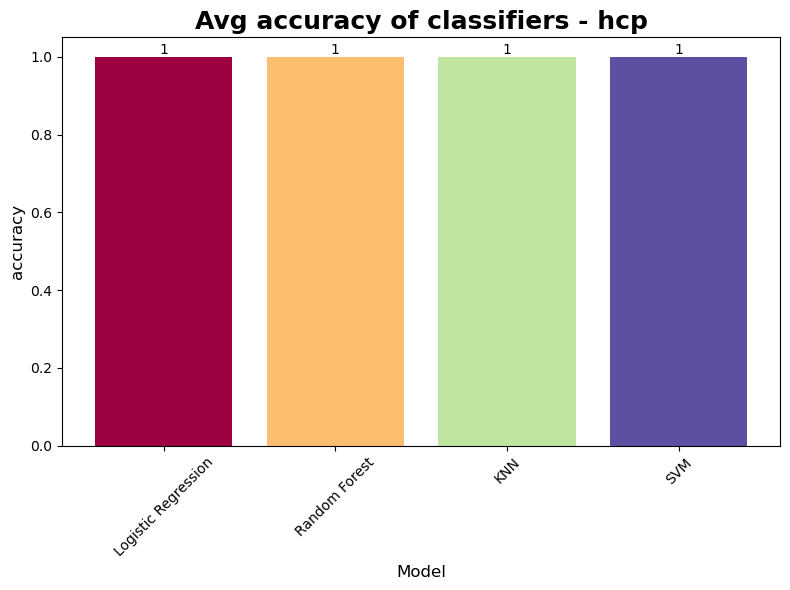

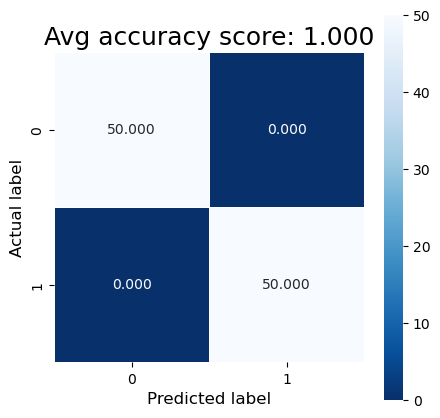

In [62]:
# Load example dataset (Iris dataset)
# iris = load_iris()
# X = iris.data
# y = iris.target

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix

scoring = 'accuracy'
class_weight = 'balanced'

# Define the classifiers and their corresponding hyperparameters
classifiers = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight=class_weight), {'C': [0.1, 1.0, 10.0]}),
    'Random Forest': (RandomForestClassifier(class_weight=class_weight), {'n_estimators': [10, 50, 100]}), #max_depth: None for unlimited depth.
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}), # KNN has no class weight parameter
    'SVM': (SVC(class_weight=class_weight), {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']})
}

# also implement class weight = 'balanced'?

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform nested cross-validation for each classifier

#cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_outer = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#cv_outer = KFold(n_splits=4, shuffle=True, random_state=42)

#cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_inner = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
#cv_inner = KFold(n_splits=4, shuffle=True, random_state=42)

results = {}
best_score = 0.0

colors = plt.cm.Spectral(np.linspace(0, 1, len(classifiers)))  # Generate a color map for models

plt.figure(figsize=(8, 6))  # Create a single figure to plot all learning curves

for i, (clf_name, (clf, param_grid)) in enumerate(classifiers.items()):
        # inner loop
        clf = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=cv_inner, n_jobs=-1)        
        # outer loop
        train_sizes, train_scores, val_scores = learning_curve(clf, X, y, cv=cv_inner, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
        avg_score = np.mean(val_scores, axis=1)
        results[clf_name] = avg_score[-1]

        if avg_score[-1] > best_score:
            best_score = avg_score[-1]
            best_model = clf
            best_model_name = clf_name

        # Plot learning curves
        plt.plot(train_sizes, np.mean(train_scores, axis=1), '-', label='Train '+scoring+' - ' +clf_name, color=colors[i])
        plt.plot(train_sizes, avg_score, '--', label='Val '+scoring+' - '+clf_name, color=colors[i])

plt.xlabel('Training Set Size', fontsize=label_fontsize)
plt.ylabel(scoring, fontsize=label_fontsize)
plt.title('Learning curves for different models - '+dataset, fontsize=title_fontsize, weight='bold')
plt.legend(bbox_to_anchor=(1, 0.7))
plt.grid(True)
#plt.show()
plt.savefig(main_dir+'/figures/'+dataset+'_learning_curves.png', bbox_inches='tight')

# Plot the scoring as a function of the different models
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
model_names = [name for name, _ in sorted_results]
model_scores = [score for _, score in sorted_results]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, model_scores, color=colors[:len(model_names)])
plt.bar_label(bars)
plt.xlabel('Model', fontsize=label_fontsize)
plt.ylabel(scoring, fontsize=label_fontsize)
plt.title('Avg '+ scoring +' of classifiers - '+dataset, fontsize=title_fontsize, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig(main_dir+'/figures/'+dataset+'_classification_barplot.png', bbox_inches='tight')

# Output the confusion matrix for the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(f"Confusion Matrix for the Best Model ({best_model_name}):\n{cm}\n")
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label', fontsize=label_fontsize)
plt.xlabel('Predicted label', fontsize=label_fontsize)
plt.title('Avg '+scoring+' score: {:.3f}'.format(best_model.best_score_), size = title_fontsize)
plt.savefig(main_dir+'/figures/'+dataset+'_confusion_mat.png', bbox_inches='tight')

# Report back the optimal hyperparameters for the selected model
best_params = best_model.best_params_
print(f"Optimal hyperparameters for the best model ({best_model_name}): {best_params}")

### 3.3 Plotting accurcy (for best classifier) for different feature models

In [64]:
def classification_pipeline(eta, dataset, scoring = 'accuracy', class_weight = 'balanced', main_dir='/work3/s174162/speciale'):
    # reshape to eta to (n_samples, n_features) where n_samples = S and n_features = noc*(noc+1)/2
    X = get_X_data(eta) # feature data
    #print('x_data shape:', x_data.shape)

    # create target/label data: y
    if dataset == 'hcp':
        S1 = 250
        S2 = 250
        y = np.concatenate((np.zeros(S1), np.ones(S2)))
    elif dataset == 'decnef':
        y = np.load(os.path.join(main_dir, 'data', 'decnef', 'schizo_mask.npy')) # maybe it needs to be 0 and 1 and not False and True
    else:
        print('dataset not found')
    #print('y shape:', y.shape)

    # Define the classifiers and their corresponding hyperparameters
    classifiers = {
        'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight=class_weight), {'C': [0.1, 1.0, 10.0]}),
        'Random Forest': (RandomForestClassifier(class_weight=class_weight), {'n_estimators': [10, 50, 100]}), #max_depth: None for unlimited depth.
        'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}), # KNN has no class weight parameter
        'SVM': (SVC(class_weight=class_weight), {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']})
    }

    # Standarize data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Perform nested cross-validation for each classifier
    cv_outer = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    cv_inner = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

    results = {}
    best_score = 0.0

    # loop over different classifiers
    for i, (clf_name, (clf, param_grid)) in enumerate(classifiers.items()):
            # inner cv loop
            clf = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=cv_inner, n_jobs=-1)
            # outer cv loop
            train_sizes, train_scores, val_scores = learning_curve(clf, X, y, cv=cv_inner, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
            avg_score = np.mean(val_scores, axis=1)
            results[clf_name] = avg_score[-1]

            if avg_score[-1] > best_score:
                best_score = avg_score[-1]
                best_clf = clf
                best_clf_name = clf_name

    # Output the confusion matrix for the best model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    best_clf.fit(X_train, y_train)
    
    return best_clf #maybe just best_model.best_score_  and best_model.best_params_

In [65]:
def plot_acc_feat(dataset, df, scoring = 'accuracy', class_weight = 'balanced', main_dir='/work3/s174162/speciale', label_fontsize=label_fontsize, subtitle_fontsize=subtitle_fontsize, title_fontsize=title_fontsize, fig_name=None):
   
    # Input:  
    # dataset: 'hcp' or 'decnef'
    # df: dataframe with experiment overview
 
    # Output: plot of parameter as a function of Gibbs iterations

    # Sort by dataset and relevant columns
    if dataset == 'hcp' or dataset == 'decnef':
        df_dataset = df.loc[df.dataset==dataset].sort_values(by=['n_rois','threshold_annealing','model_type','splitmerge','noc'], ascending=True).reset_index()
        unique_models = df_dataset[['model_type', 'n_rois', 'noc']].drop_duplicates()
    elif dataset == 'synthetic':
        df_dataset = df.loc[df.dataset==dataset].sort_values(by=['N','K','S1','S2','Nc_type', 'eta_similarity', 'model_type','splitmerge','noc'], ascending=True).reset_index()
        unique_models = df_dataset[['model_type', 'K', 'S1', 'Nc_type', 'eta_similarity', 'noc']].drop_duplicates()
    else:
        print('unknown dataset')

    cmap = plt.get_cmap('viridis')
    
    noc_values = df_dataset['noc'].unique()
    num_noc = len(noc_values)
    
    label_list = []
    color_list = []
    MAPpar_data = []
    for _, row in unique_models.iterrows():
        
        model_type = row['model_type']
        noc = row['noc']
        if dataset == 'hcp' or dataset == 'decnef':
            n_rois = row['n_rois']
            model_df = df_dataset.loc[(df_dataset['model_type'] == model_type) & (df_dataset['n_rois'] == n_rois) & (df_dataset['noc'] == noc)]
            
        elif dataset == 'synthetic':
            K = row['K']
            S1 = row['S1']
            Nc_type = row['Nc_type']
            eta_similarity = row['eta_similarity']
            model_df = df_dataset.loc[(df_dataset['model_type'] == model_type) & (df_dataset['K'] == K) & (df_dataset['S1'] == S1) & 
                                      (df_dataset['Nc_type'] == Nc_type) & (df_dataset['eta_similarity'] == eta_similarity) & (df_dataset['noc'] == noc)]
        else:
            print('unknown dataset')

        noc_color_index = list(noc_values).index(noc) % num_noc
        
        if dataset == 'hcp' or dataset == 'decnef':
            color_intensity = n_rois / df_dataset['n_rois'].max()  # Higher n_rois, darker intensity
            label = f"{model_type}_nrois{n_rois}_noc{noc}"
        elif dataset == 'synthetic':
            color_intensity = K / df_dataset['K'].max()  # Higher K, darker intensity
            label = f"{model_type}_K{K}_S1{S1}_Nc_type{Nc_type}_eta_similarity{eta_similarity}_noc{noc}"
        else:
            print('unknown dataset')
        label_list.append(label)
        
        color = cmap((color_intensity + noc_color_index) / num_noc)
        color_list.append(color)
        
        ####### FOR EACH FEATURE MODEL: EXTRACT FEATURES (ETA) AND PERFORM CROSS VALIDATION TO GET BEST MODEL AND ACCURACY SCORE #######
        score_data = []
        for _, model_row in model_df.iterrows():
            folders = model_row['exp_name_list']
            paths = [os.path.join(main_dir, 'results', dataset, folder) for folder in folders]
            score_list = []
            for folder in paths:
                sample = np.load(os.path.join(folder, 'model_sample.npy'), allow_pickle=True).item()
                eta = sample['MAP']['eta']
                best_clf = classification_pipeline(eta=eta, dataset=dataset, scoring = scoring, class_weight = class_weight) # CLASSIFICATION PIPELINE
                score_list.append(best_clf.best_score_)
            score_data.append(score_list)
            
    fig, ax = plt.subplots()
    bp = ax.boxplot(score_data, patch_artist=True)#, boxprops=dict(facecolor=color_list))
    num_models = len(label_list)
    ax.set_xticks(range(1, num_models + 1))
    ax.set_xticklabels(label_list, rotation=90)
    for box, color in zip(bp['boxes'], color_list):
        box.set_facecolor(color)
    ax.set_ylabel(scoring + ' distribution', fontsize=label_fontsize)
    ax.set_title('Boxplots of '+scoring+' - ' + dataset, fontsize=title_fontsize, weight='bold')
    ax.yaxis.grid(True)
    if fig_name is not None:
        plt.savefig(main_dir+'/figures/'+dataset+'_'+fig_name+'.png', bbox_inches='tight')    
    else:
        plt.savefig(main_dir+'/figures/'+dataset+'_boxplot_'+scoring+'.png', bbox_inches='tight')    


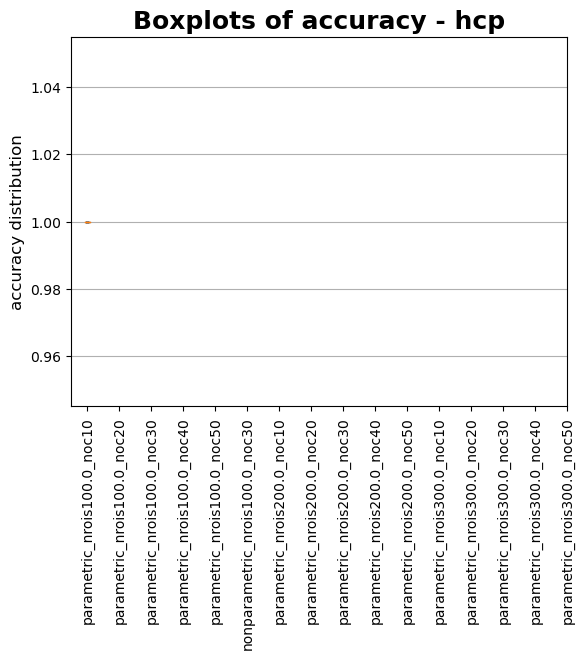

In [61]:
plot_acc_feat(dataset=dataset, df=df)

In [66]:
plot_acc_feat(dataset='decnef', df=df)